<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments</font></b>

# Introduction

## Contexte

Le projet se situe dans le cadre des efforts de la ville de Seattle pour atteindre son objectif de neutralité carbone d'ici 2050, un enjeu majeur dans la lutte contre le changement climatique. L'accent est mis sur l'analyse de la consommation énergétique et des émissions de dioxyde de carbone (CO2) des bâtiments non résidentiels, une composante significative de l'empreinte carbone de la ville. Pour cela, la ville dispose de données collectées en 2016, reflétant les consommations et émissions des bâtiments à cette période. Ces données, bien que précieuses, sont coûteuses et laborieuses à obtenir, d'où l'intérêt de développer un modèle prédictif capable d'estimer ces indicateurs pour les bâtiments non encore analysés, basé sur des caractéristiques structurelles telles que la taille, l'usage, la date de construction, ou encore la situation géographique des bâtiments.

## Objectifs

Tout d'abvord, réaliser une analyse exploratoire des données disponibles afin d'identifier les tendances, les anomalies et les relations potentielles entre les différentes variables. Et ensuite tester et comparer différents modèles de machine learning pour prédire avec précision la consommation totale d'énergie et les émissions de CO2 des bâtiments non résidentiels, sans données de consommation annuelle future, pour éviter toute fuite de données. Un intérêt particulier est porté à l'évaluation de l'utilité de l'"ENERGY STAR Score", un indicateur potentiellement pertinent mais complexe à calculer avec les méthodes actuelles.


## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython.display import Image

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb.ipynb',
 'Deveau_Estelle_2_notebook_prediction_EnergyUse_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'svg']

In [3]:
os.listdir("data/sources/")

['2016_Building_Energy_Benchmarking.csv']

In [4]:
path     = "./data/sources/"
filename = "2016_Building_Energy_Benchmarking.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exploration des données

## Quick tour

In [7]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [8]:
data.shape

(3376, 46)

In [9]:
data.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

In [10]:
data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [11]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 12.85 %


In [13]:
percent_missing_values =  round((missing_values_count / len(data)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

,Nombre de valeurs manquantes,Pourcentage de valeurs manquantes
OSEBuildingID,0,0.00
DataYear,0,0.00
BuildingType,0,0.00
PrimaryPropertyType,0,0.00
PropertyName,0,0.00
Address,0,0.00
City,0,0.00
State,0,0.00
ZipCode,16,0.47
TaxParcelIdentificationNumber,0,0.00


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

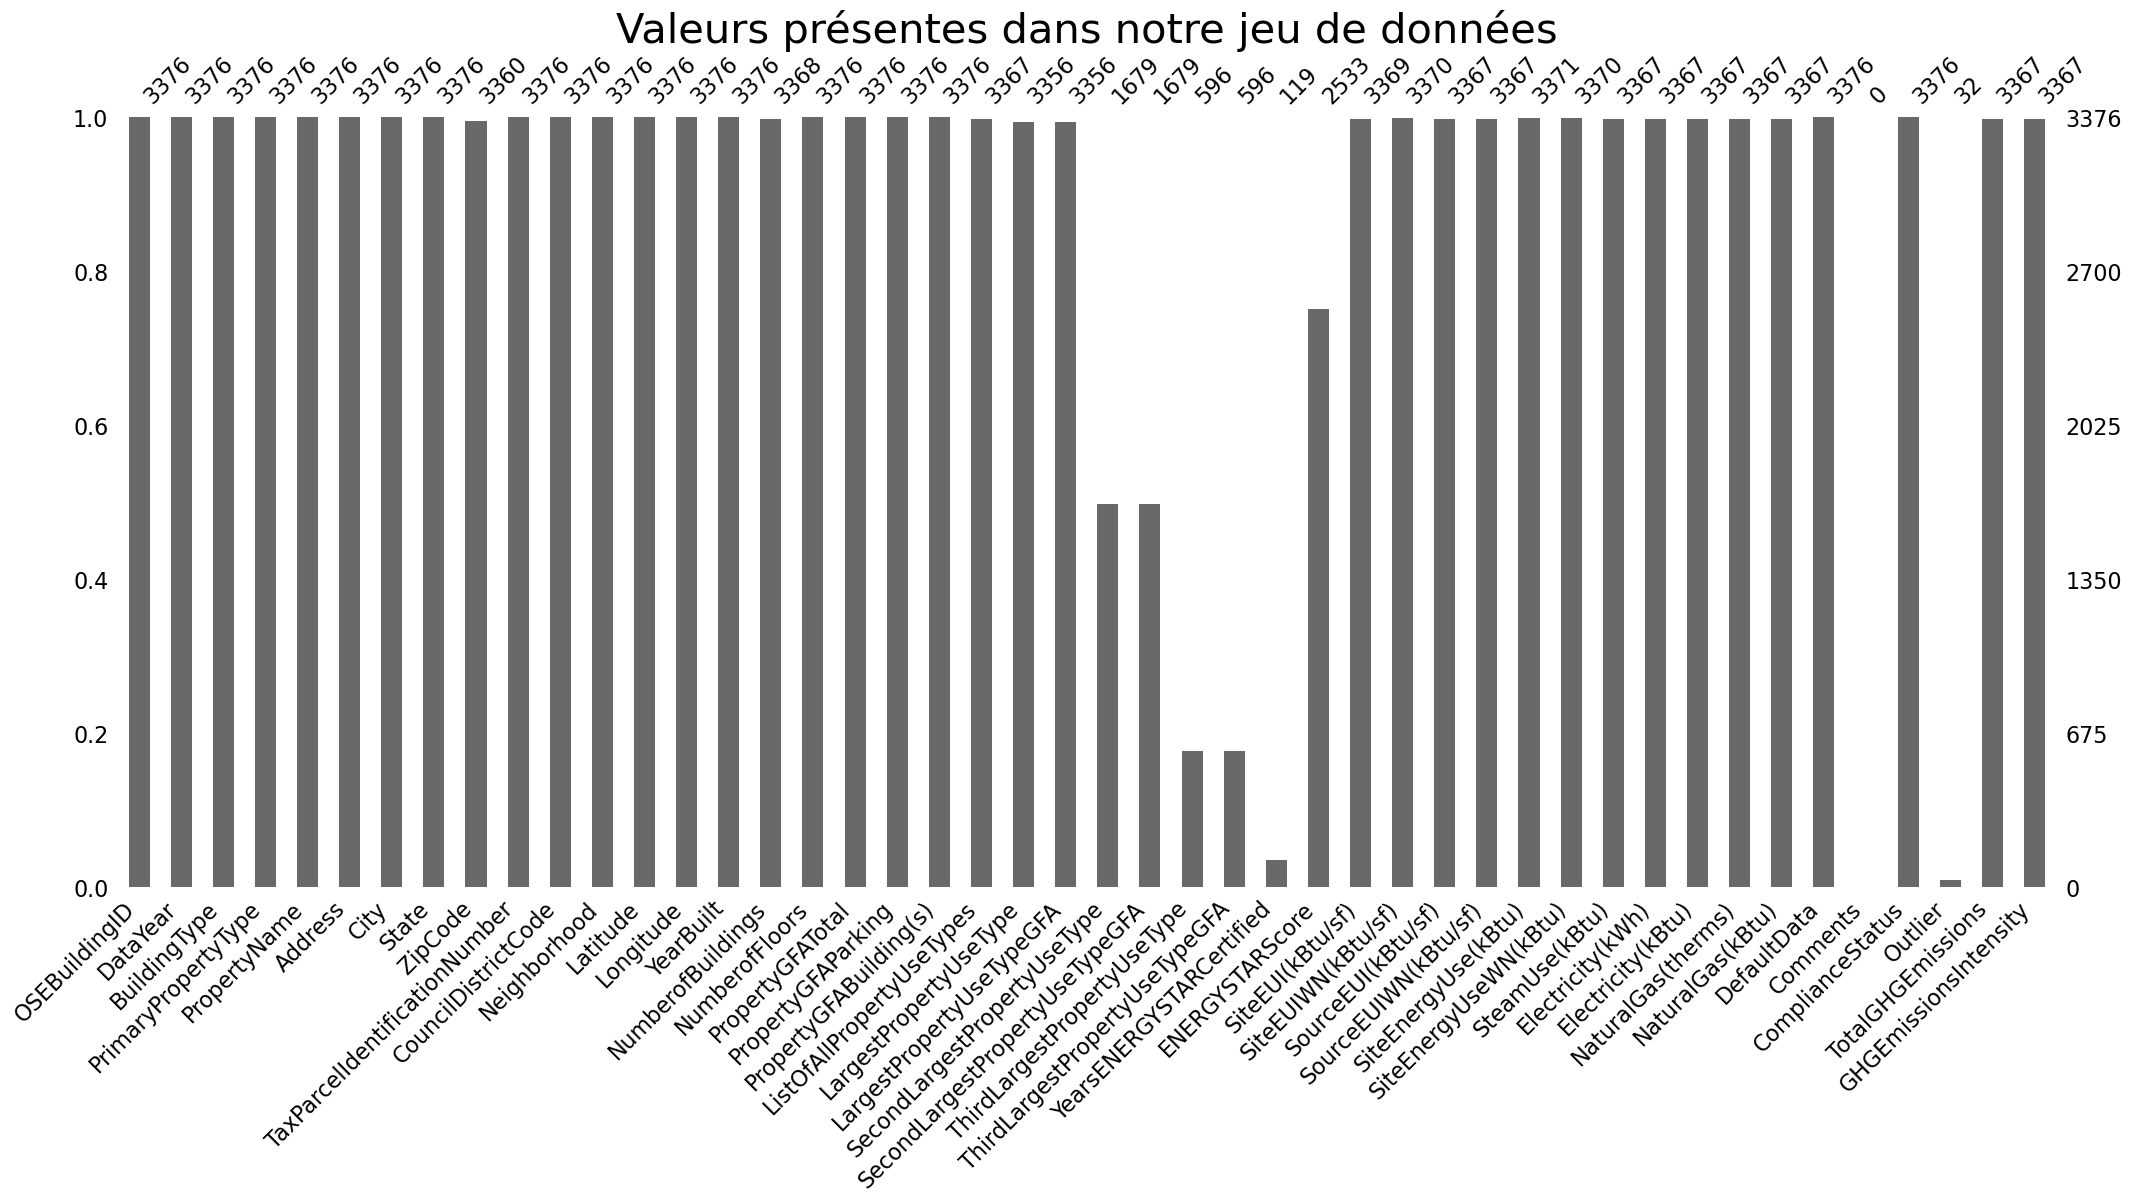

In [14]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(data)

<Axes: >

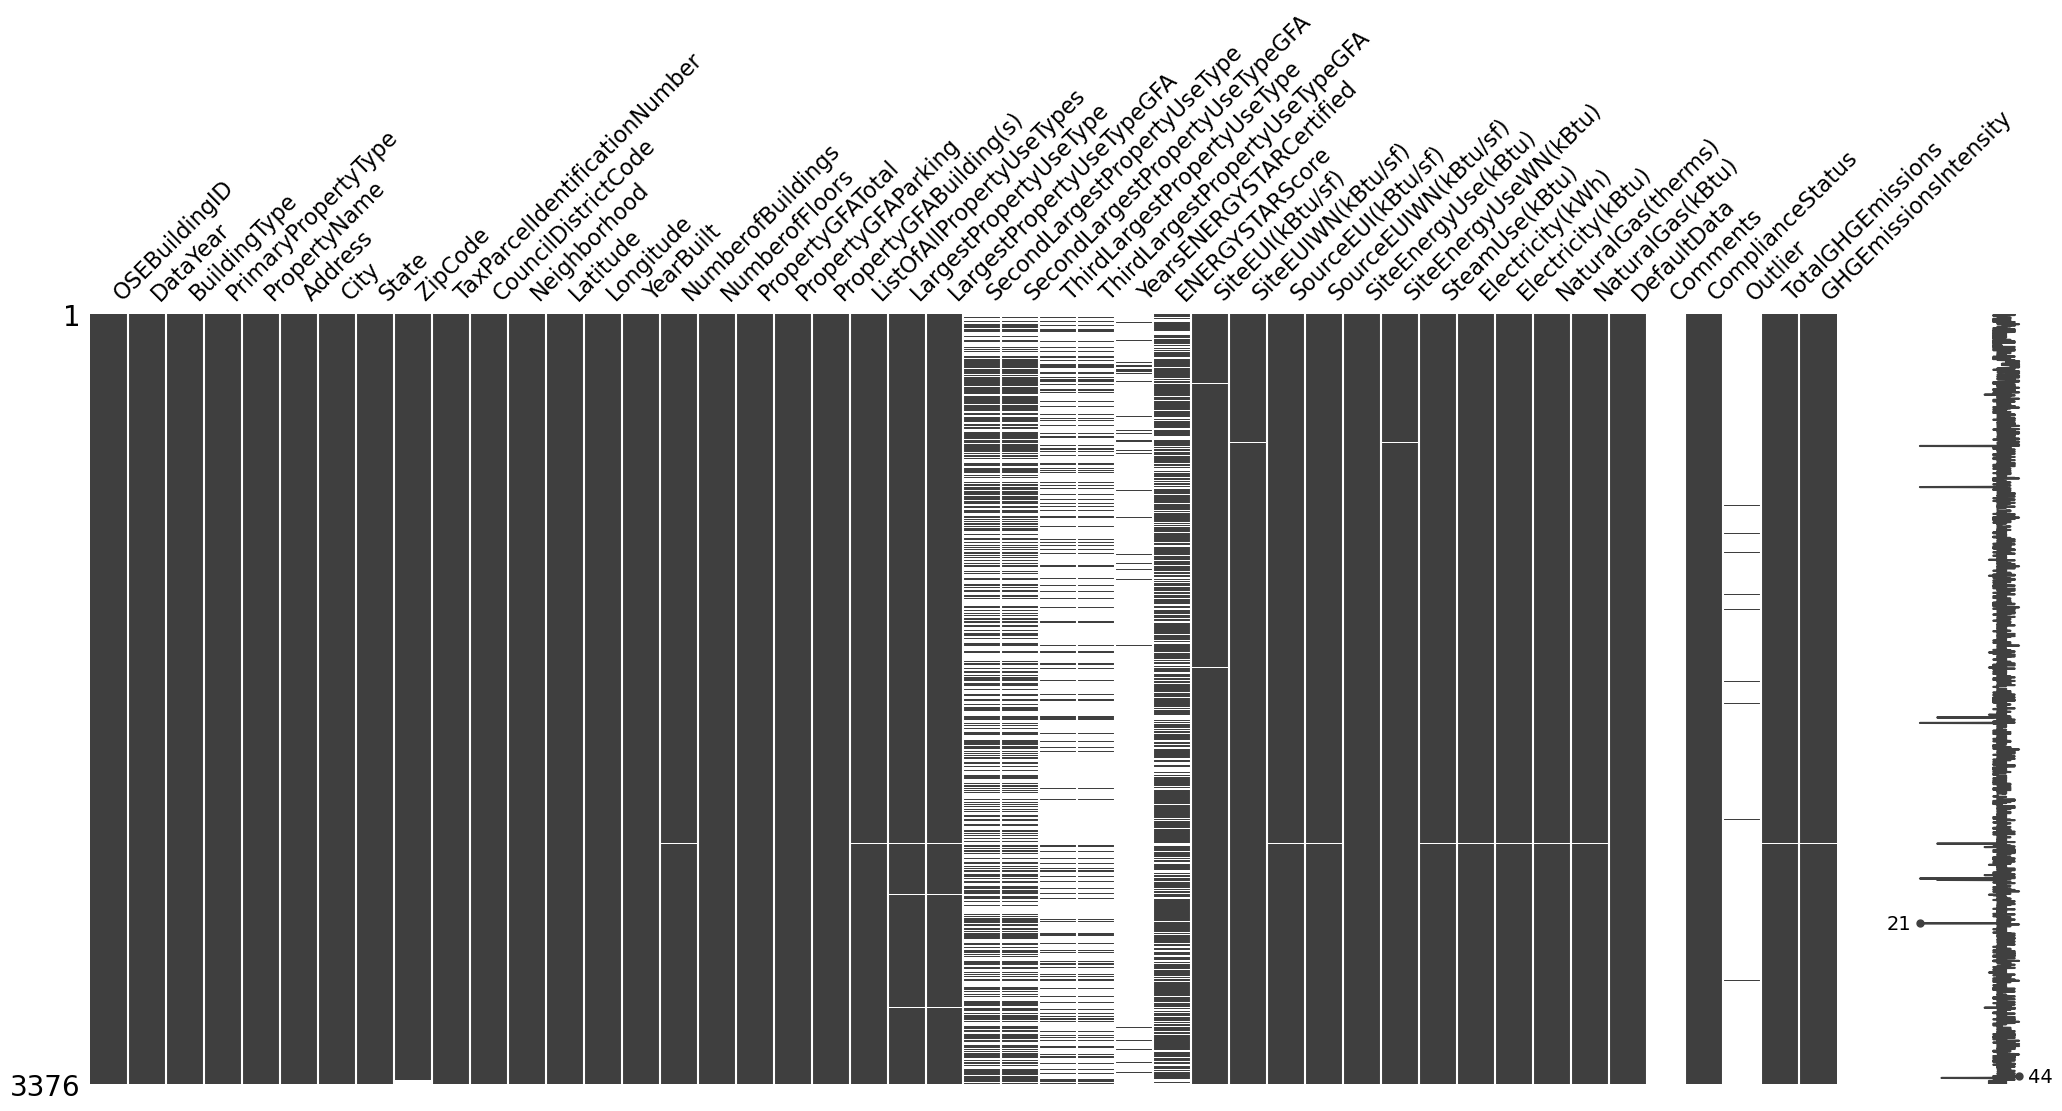

In [15]:
msno.matrix(data)

<Axes: >

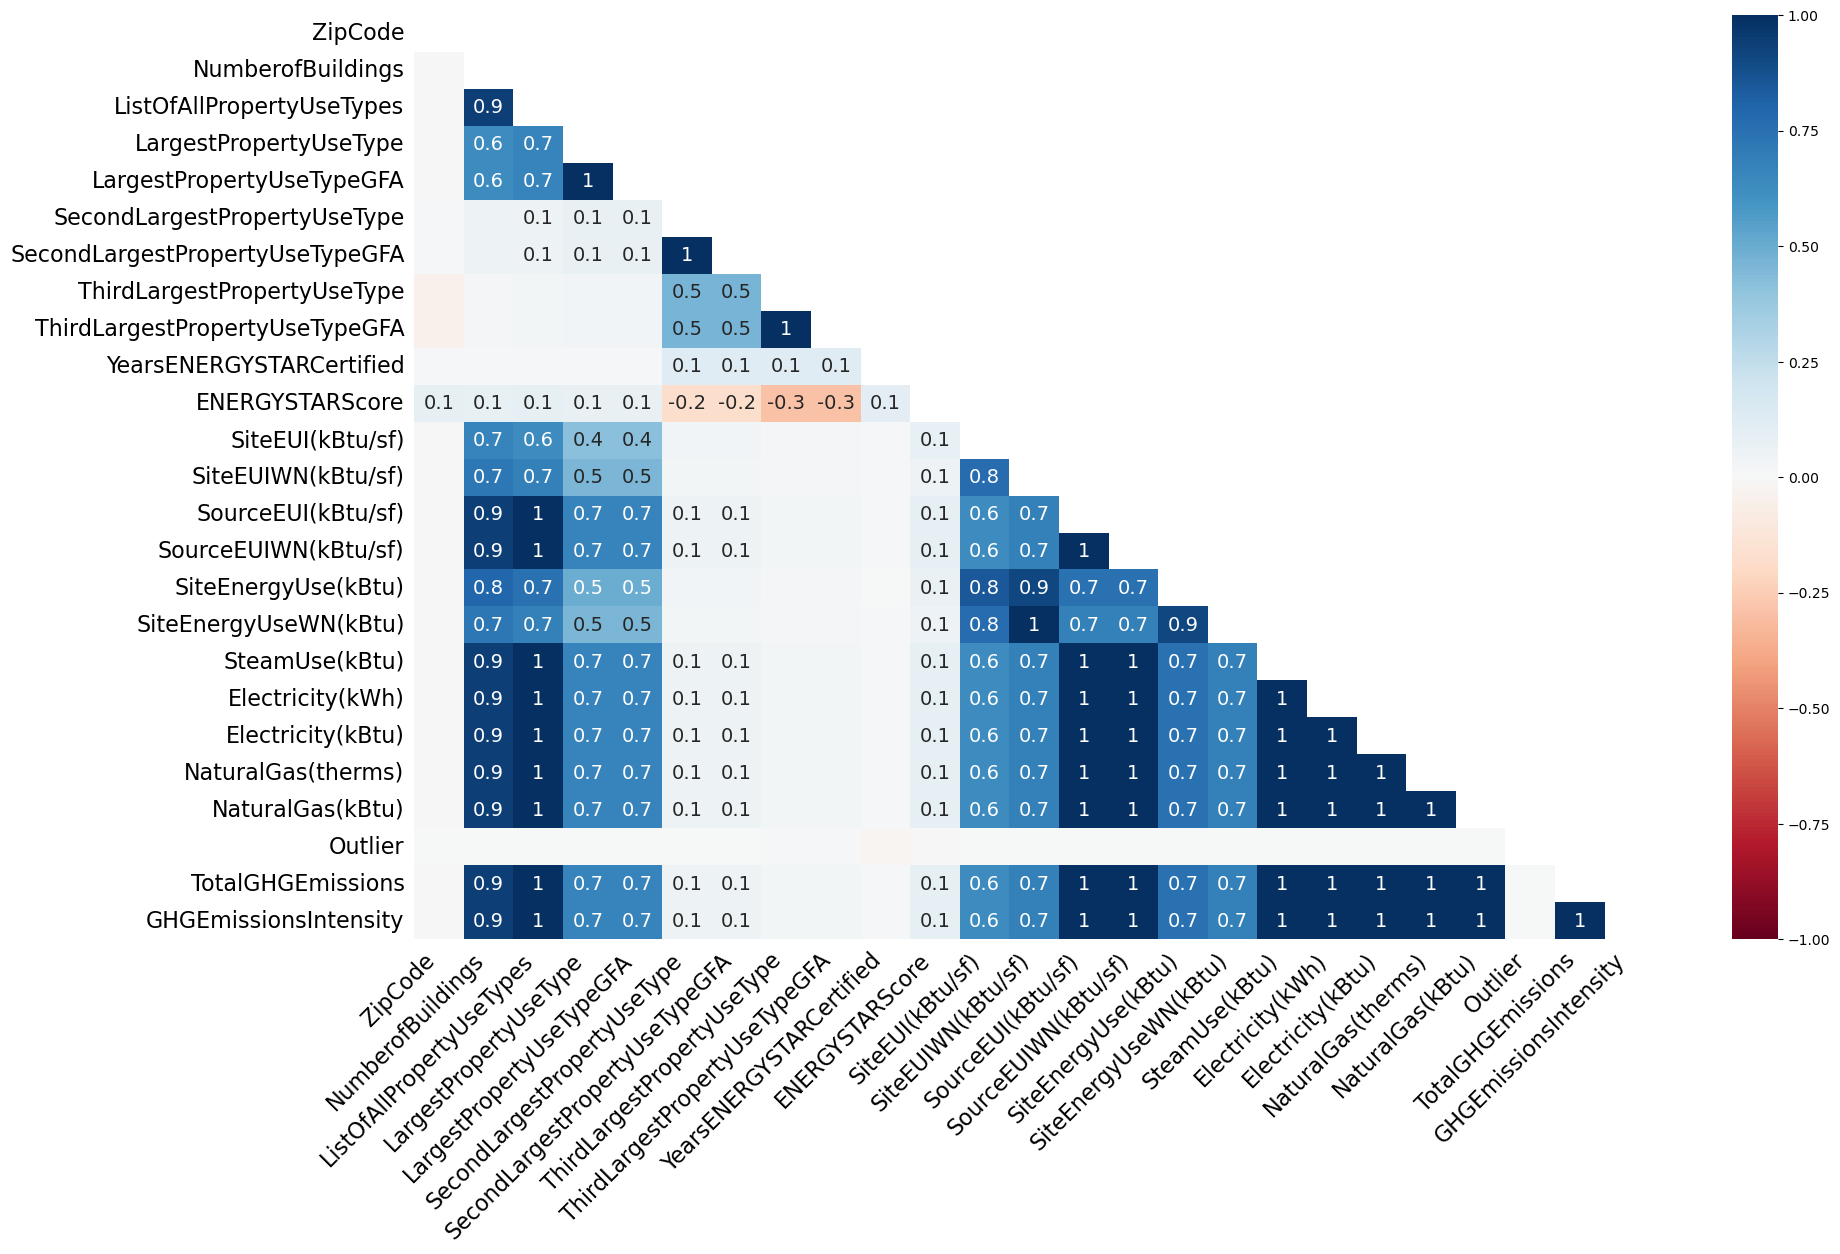

In [16]:
msno.heatmap(data)

## Compréhension des Variables

Différents groupes de variables :<br>

- Identification :<br>
OSEBuildingID
PropertyName
TaxParcelIdentificationNumber<br>
=> on les garde le temps de vérifier les doublons

- Localisation :<br>
Address, ZipCode, City, State
CouncilDistrictCode
Neighborhood
Latitude, longitude
=> on garde adresse et zipcode pour vérifier les outliers manuellement<br>
=> City et State ont des valeurs uniques => supprimés<br>
=> Latitude, longitude pour vérifier les outliers<br>
=> Zipcode, CouncilDistrictCode Neighborhood => On choisi Neighborhood car pas de valeurs manquantes et plus de catégories<br>

- Type de batiment/utilisation :<br>
BuildingType
ListOfAllPropertyUseTypes 	
PrimaryPropertyType
LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType<br>
=> on garde tout pour le moment même si primarypropertytype et largestpropertytype semblent similaires<br>

- Surface :<br>
PropertyGFATotal
LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA<br>
=> on garde tout <br>

- Energie :<br>
SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf) 	
SiteEnergyUse(kBtu), **SiteEnergyUseWN(kBtu)**
SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms),  NaturalGas(kBtu)<br>
=> on conserve tout pour les vérifications des valeurs mais on ne conservera pas les fuites de données par la suite<br>

- GES :<br>
**TotalGHGEmissions**, GHGEmissionsIntensity<br>
=> On garde tout pour le moment

- Bâtiment :<br>
YearBuilt
NumberofBuildings
NumberofFloors<br>
=> on garde tout <br>

- Energystarscore :<br>
YearsENERGYSTARCertified
**ENERGYSTARScore**<br>
=> on garde seulement l'EnergyStarScore, il y a trop de valeurs manquantes pour l'année<br>

- Autre :<br>
DefaultData
Comments 
ComplianceStatus
Outlier<br>
=> Comments à supprimer car vide, les autres à regarder en détail

In [17]:
cols_to_drop = ['DataYear', 'City', 'State', 'CouncilDistrictCode', 'TaxParcelIdentificationNumber', 
                'YearsENERGYSTARCertified', 'Comments']

# Liste de toutes les colonnes à conserver
cols_to_keep = data.columns.difference(cols_to_drop)

# Nettoyage des Données

## Format des données

In [18]:
data[cols_to_keep].dtypes

Address                             object
BuildingType                        object
ComplianceStatus                    object
DefaultData                           bool
ENERGYSTARScore                    float64
Electricity(kBtu)                  float64
Electricity(kWh)                   float64
GHGEmissionsIntensity              float64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
Latitude                           float64
ListOfAllPropertyUseTypes           object
Longitude                          float64
NaturalGas(kBtu)                   float64
NaturalGas(therms)                 float64
Neighborhood                        object
NumberofBuildings                  float64
NumberofFloors                       int64
OSEBuildingID                        int64
Outlier                             object
PrimaryPropertyType                 object
PropertyGFABuilding(s)               int64
PropertyGFAParking                   int64
PropertyGFA

## Recherche des doublons

In [19]:
nb_doublons_code = data.duplicated(subset=["OSEBuildingID"]).sum()
print('Nombre de doublons sur le OSEBuildingID :', nb_doublons_code)

Nombre de doublons sur le OSEBuildingID : 0


In [20]:
nb_doublons_add = data.duplicated(subset=['Address', 'PropertyName']).sum()
print('Nombre de doublons sur l\'adresse :', nb_doublons_add)

Nombre de doublons sur l'adresse : 0


## Vérification des données

In [21]:
df = data.copy()

In [22]:
def find_outliers(df, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df[outlier_var].quantile(0.25)
    q3 = df[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Filtrer les outliers
    outliers = df[(df[outlier_var] < lower_bound) | (df[outlier_var] > upper_bound)]
    return outliers

In [23]:
def find_outliers_by_group(df, groupby_var, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df.groupby(groupby_var)[outlier_var].quantile(0.25)
    q3 = df.groupby(groupby_var)[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Initialiser une liste pour stocker les DataFrame des outliers
    outliers_list = []

    # Identifier les outliers pour chaque groupe
    for group in df[groupby_var].dropna().unique():
        lower_bound_group = lower_bound.get(group, np.nan)
        upper_bound_group = upper_bound.get(group, np.nan)
        # Utiliser les valeurs obtenues pour filtrer les outliers, en vérifiant aussi que les bornes ne sont pas NaN
        if not np.isnan(lower_bound_group) and not np.isnan(upper_bound_group):
            outliers_group = df[(df[groupby_var] == group) & 
                                ((df[outlier_var] < lower_bound_group) | 
                                 (df[outlier_var] > upper_bound_group))]
            if not outliers_group.empty:
                outliers_list.append(outliers_group)

    # Concaténer les DataFrame des outliers, en vérifiant d'abord si la liste n'est pas vide
    if outliers_list:
        outliers = pd.concat(outliers_list)
        return outliers
    else:
        return pd.DataFrame()  # Retourner un DataFrame vide si aucun outlier n'est trouvé

### BuildingType

In [24]:
print("Valeurs uniques pour BuildingType dans data:", data['BuildingType'].unique())

Valeurs uniques pour BuildingType dans data: ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [25]:
df = df[~df['BuildingType'].str.contains("Multifamily", na=False)].copy()

In [26]:
df.shape

(1668, 46)

### ComplianceStatus

In [27]:
print(df['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       1548
Error - Correct Default Data      88
Non-Compliant                     18
Missing Data                      14
Name: count, dtype: int64


ComplianceStatus :

    - Non-Compliant indique que le bâtiment n'a pas satisfait certaines exigences de reporting ou de performance, ce qui pourrait signifier que les données associées sont incomplètes ou peu fiables.
    - Les bâtiments avec des erreurs dans leur statut de conformité ("Error") peuvent également souffrir de problèmes de données qui compromettent leur utilité pour l'analyse et la modélisation.
    
Inclure ces bâtiments pourrait introduire un biais ou de l'incertitude dans vos analyses.<br>
=> Suppression, On conserve les Compliant et Missing Data


In [28]:
df = df[~df['ComplianceStatus'].str.contains("Non-Compliant", na=False)].copy()
df = df[~df['ComplianceStatus'].str.contains("Error", na=False)].copy()
df = df.drop(columns=['ComplianceStatus'])

### DefaultData

In [29]:
print(df['DefaultData'].value_counts())

DefaultData
False    1562
Name: count, dtype: int64


Les valeurs par défaut peuvent avoir biaisé nos données, nous choisissons de supprimer ces batiments.

In [30]:
df = df[df['DefaultData'] != True]
df = df.drop(columns=['DefaultData'])

### Outlier

In [31]:
print("Valeurs uniques pour Outlier dans data:", data['Outlier'].unique())

Valeurs uniques pour Outlier dans data: [nan 'High outlier' 'Low outlier']


On conserve pour le moment pour vérifier s'il y a un impact sur nos modèles.

### Latitude et Longitude

Seattle :<br>
    - Longitude minimale : aux alentours de -122.436 (ouest)<br>
    - Longitude maximale : aux alentours de -122.255 (est)

In [32]:
# Définir les limites de longitude pour Seattle
longitude_min = -122.436
longitude_max = -122.255

# Sélectionner les lignes en dehors de cette fourchette de longitude
outliers_longitude = df[(df['Longitude'] < longitude_min) | (df['Longitude'] > longitude_max)]

# Afficher les valeurs aberrantes
outliers_longitude[['Address', 'Latitude', 'Longitude']]

,Address,Latitude,Longitude


### Neighborhood

In [33]:
print("Valeurs uniques pour Neighborhood dans data:", df['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'NORTHEAST' 'EAST' 'Central' 'MAGNOLIA / QUEEN ANNE'
 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD' 'NORTHWEST' 'CENTRAL'
 'SOUTHWEST' 'DELRIDGE' 'SOUTHEAST' 'NORTH' 'North' 'Delridge' 'Ballard'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']


In [34]:
# Corrections
df['Neighborhood'] = df['Neighborhood'].str.upper()
df['Neighborhood'] = df['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print("Valeurs uniques pour Neighborhood dans data:", df['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'NORTHEAST' 'EAST' 'CENTRAL' 'MAGNOLIA / QUEEN ANNE'
 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD' 'NORTHWEST' 'SOUTHWEST'
 'DELRIDGE' 'SOUTHEAST' 'NORTH']


### NumberofBuildings

In [35]:
# Compter et trier le nombre de valeurs
NumberofBuildings_counts = df['NumberofBuildings'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofBuildings': NumberofBuildings_counts})

,NumberofBuildings
NumberofBuildings,
111.0,1
27.0,1
23.0,1
14.0,2
11.0,1
10.0,1
9.0,1
8.0,2
7.0,1


Il y a forcément au moins 1 bâtiment par adresse, la valeur la plus fréquente étant 1 on remplace les 0 par 1

In [36]:
df.loc[df['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1.

Les adresses avec plus de 10 bâtiments sont à vérifier.

In [37]:
# Sélectionner les lignes où le nombre de bâtiments est supérieur à 10
buildings_over_10 = df[df['NumberofBuildings'] > 10]
buildings_over_10[['Address', 'ZipCode', 'NumberofBuildings', 'PrimaryPropertyType']]

,Address,ZipCode,NumberofBuildings,PrimaryPropertyType
105,6000 16th Ave SW,98106.0,27.0,University
128,9600 COLLEGE WAY N,98103.0,11.0,University
162,1420 S Trenton,98108.0,14.0,Large Office
1862,1900 West Nickerson Street,98119.0,23.0,Other
2325,3307 3rd Ave. W,98119.0,14.0,University
3274,NE 45th St & Brooklyn Ave,98105.0,111.0,University


Nombre de batiments pas abérrants après vérifications sur google maps.

### NumberofFloors 

In [38]:
# Compter et trier le nombre de valeurs
NumberofFloors_counts = df['NumberofFloors'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofFloors': NumberofFloors_counts})

,NumberofFloors
NumberofFloors,
99,1
76,1
63,1
56,1
55,1
49,1
47,1
46,1
42,5


In [39]:
# Colonnes à afficher
cols_to_display = ['Address', 'NumberofFloors', 'PrimaryPropertyType']
print(df[cols_to_display].loc[df['NumberofFloors'] >60])

                       Address  NumberofFloors PrimaryPropertyType
233           700 Fifth Avenue              63        Large Office
559             701 5th Avenue              76        Large Office
1359  5801 Beacon Avenue South              99    Worship Facility


A corriger : <br>
    5801 Beacon Avenue South correspond à une église => remplacer par 1

In [40]:
df.loc[df['Address'] == '5801 Beacon Avenue South', 'NumberofFloors'] = 1

In [41]:
outliers = find_outliers_by_group(df, 'PrimaryPropertyType', 'NumberofFloors', 3)
if not outliers.empty:
    display(outliers[['Address', 'NumberofFloors', 'PrimaryPropertyType']])
else:
    print("Aucun outlier trouvé.")

,Address,NumberofFloors,PrimaryPropertyType
2,1900 5th Avenue,41,Hotel
13,1113 6th Ave,33,Hotel
49,1400 6th Avenue,34,Hotel
15,1000 Fourth Avenue,11,Other
20,516 3RD AVE,10,Other
21,500 5TH AVE,19,Other
119,1900 9th Ave.,11,Other
187,1122 3rd Ave,15,Other
298,120 Lenora,12,Other
558,2001 6th Ave,33,Other


Un restaurant avec 13 étage et après vérification sur la carte, cela semble être une erreur de saisie.
Mise à 0 temporaire pour lui appliquer la moyenne.<br>
Après vérification, les autres bâtiments ne sont pas des outliers.

In [42]:
df.loc[df['Address'] == '1411 1st Avenue', 'NumberofFloors'] = 0

Aux USA on compte le rez de chaussée comme un étage. Il y a donc necessairement au moins 1 étage par batiment.
Nous allons donc remplacer les valeurs à 0 par la moyenne en fonction de leur PrimaryPropertyType.

In [43]:
# Calculer la médiane du nombre d'étages pour chaque type de propriété et convertir en entiers
mean_floors_by_type = df[df['NumberofFloors'] > 0].groupby('PrimaryPropertyType')['NumberofFloors'].median().astype(int)


# Fonction pour remplacer les zéros par la moyenne correspondante
def replace_zero_with_mean(row):
    if row['NumberofFloors'] == 0:
        return mean_floors_by_type.get(row['PrimaryPropertyType'], 1)
    else:
        return row['NumberofFloors']


In [44]:
# Appliquer la fonction à la colonne 'NumberofFloors'
df['NumberofFloors'] = df.apply(replace_zero_with_mean, axis=1)

### YearBuilt

In [45]:
print("Valeurs uniques pour YearBuilt dans data:", df['YearBuilt'].unique())

Valeurs uniques pour YearBuilt dans data: [1927 1996 1969 1926 1980 1999 1904 1998 1928 1922 2004 1930 1983 1907
 1916 1985 2001 1991 1955 1978 1989 1906 1994 1992 1961 1990 1900 1954
 1911 1973 1920 1910 1982 1908 1959 2000 1997 1962 1970 2008 1948 1965
 1929 2010 1938 1986 2002 1923 2003 1941 2006 1915 1950 1958 2009 2011
 1971 2007 1951 1964 1953 1937 1966 1963 1957 1968 1924 2005 1931 1972
 1952 1914 1913 1995 1981 1925 1976 1909 1988 1979 1947 1984 1956 1912
 1977 1960 1945 1974 1975 1946 1967 1987 1949 1940 1932 1993 1918 1905
 1902 1921 1939 1944 1917 1942 1903 2012 2013 1919 1901 1936 1935 2014
 2015]


On remplace l'année de construction par l'âge du bâtiment au moment des relevés.

In [46]:
# Calculer l'âge des bâtiments et créer la colonne 'BuildingAge'
df['BuildingAge'] = 2016 - df['YearBuilt']

# Supprimer la colonne 'YearBuilt'
df.drop(columns=['YearBuilt'], inplace=True)

### Electricity

In [47]:
def check_electricity_coherence(row):
    # Pas d'évaluation si Electricity est nan
    if pd.isna(row['Electricity(kWh)']) or pd.isna(row['Electricity(kBtu)']):
        return False

    # Conversion: 1 kWh = 3.41214 kBtu
    electricity_kwh_to_btu = row['Electricity(kWh)'] * 3.41214

    # Calculer la marge de tolérance
    lower_bound = electricity_kwh_to_btu * 0.95
    upper_bound = electricity_kwh_to_btu * 1.15

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['Electricity(kBtu)'] <= upper_bound)

In [48]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_electricity_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 2


In [49]:
outliers[['Electricity(kBtu)','Electricity(kWh)']]

,Electricity(kBtu),Electricity(kWh)
1670,3.0,1.00000
3206,-115417.0,-33826.80078


In [50]:
# Suppression des outliers du DataFrame
df = df[df['is_outlier'] == False]

# Suppression de la colonne 'is_outlier'
df = df.drop(columns=['is_outlier'])

In [51]:
outliers = find_outliers_by_group(df, 'PropertyGFATotal', 'Electricity(kBtu)', 1.5)
if not outliers.empty:
    display(outliers[['Electricity(kBtu)', 'SiteEUI(kBtu/sf)', 'PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseType', 
                      'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA']])
else:
    print("Aucun outlier trouvé.")

,Electricity(kBtu),SiteEUI(kBtu/sf),PropertyGFATotal,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA
240,30038487.0,834.400024,36000,Other,Data Center,36000.0,NaN,NaN


Pas abérrant pour un Data Center.

### NaturalGas

In [52]:
def check_natural_gas_coherence(row):
    # Pas d'évaluation si NaturalGas est nan
    if (pd.isna(row['NaturalGas(therms)']) or pd.isna(row['NaturalGas(kBtu)'])):
        return False
        
    # Conversion: 100 kBtu  = 1 therm
    natural_gas_therms_to_btu = row['NaturalGas(therms)'] * 100
    
    # Calculer la marge de tolérance
    lower_bound = natural_gas_therms_to_btu * 0.95
    upper_bound = natural_gas_therms_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['NaturalGas(kBtu)'] <= upper_bound)


In [53]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_natural_gas_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


In [54]:
# Suppression de la colonne 'is_outlier'
df = df.drop(columns=['is_outlier'])

In [55]:
outliers = find_outliers_by_group(df, 'PropertyGFATotal', 'NaturalGas(kBtu)', 1.5)
if not outliers.empty:
    display(outliers[['NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUI(kBtu/sf)','PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseType', 
                      'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA']])
else:
    print("Aucun outlier trouvé.")

,NaturalGas(kBtu),Electricity(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),SiteEUI(kBtu/sf),PropertyGFATotal,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA
2121,2277473.0,494348.0,0.0,3253334.250,77.000000,36000,Warehouse,Non-Refrigerated Warehouse,36000.0,NaN,NaN
2457,3426052.0,1218294.0,0.0,4644346.000,161.300003,28800,Hotel,Hotel,21600.0,Restaurant,7200.0
1150,736309.0,1057542.0,0.0,1945839.625,74.800003,25920,Small- and Mid-Sized Office,Office,23995.0,NaN,NaN


Ces valeurs semblent plausibles donc on les laisse.

### SteamUse

In [56]:
outliers = find_outliers_by_group(df, 'PropertyGFATotal', 'SteamUse(kBtu)', 1.5)
if not outliers.empty:
    display(outliers[['NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUI(kBtu/sf)','PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseType', 
                      'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

Aucun outlier trouvé.


### ListOfAllPropertyUseTypes

In [57]:
# Compter le nombre d'éléments dans chaque cellule de la colonne ListOfAllPropertyUseTypes avec gestion des valeurs NaN

# Étape préliminaire : Remplacer le cas particulier pour éviter le mauvais comptage
df['ListOfAllPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].apply(
    lambda x: x.replace('Personal Services (Health/Beauty, Dry Cleaning, etc)', 'PersonalServices') if pd.notna(x) else x)

df['NumberOfPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

# Pour toutes les valeurs à 0 de NumberOfPropertyUseTypes, ajuster en fonction de l'existence de Third et SecondLargestPropertyUseType
for index, row in df.iterrows():
    if row['NumberOfPropertyUseTypes'] == 0:
        if row['ThirdLargestPropertyUseType'] != 'None':
            df.at[index, 'NumberOfPropertyUseTypes'] = 3
        if row['SecondLargestPropertyUseType'] != 'None':
            df.at[index, 'NumberOfPropertyUseTypes'] = 2
        else:
            df.at[index, 'NumberOfPropertyUseTypes'] = 1

# Supprimer l'ancienne colonne
if 'ListOfAllPropertyUseTypes' in df.columns:
    df = df.drop(columns=['ListOfAllPropertyUseTypes'])

### GHGEmissions

In [58]:
def check_TotalGHGEmissions(row):
    # Pas d'évaluation si TotalGHGEmissions est nan
    if (pd.isna(row['TotalGHGEmissions']) or pd.isna(row['GHGEmissionsIntensity'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['GHGEmissionsIntensity'] * 0.9 * row['PropertyGFATotal'] / 1000 # /1000 pour la conversion d'unité
    upper_bound = row['GHGEmissionsIntensity'] * 1.1 * row['PropertyGFATotal'] / 1000

    # La condition vérifie si la valeur est hors de la marge de tolérance
    return not(lower_bound <= row['TotalGHGEmissions'] <= upper_bound)

In [59]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_TotalGHGEmissions, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [60]:
# Créer une nouvelle colonne pour le calcul
copy_outliers = outliers.copy()
copy_outliers['Calculated_GHG'] = copy_outliers['GHGEmissionsIntensity'] * copy_outliers['PropertyGFATotal'] / 1000

copy_outliers[['GHGEmissionsIntensity', 'TotalGHGEmissions', 'Calculated_GHG', 'PropertyGFATotal', 'PrimaryPropertyType', 
               'LargestPropertyUseType', 'SecondLargestPropertyUseType']]

,GHGEmissionsIntensity,TotalGHGEmissions,Calculated_GHG,PropertyGFATotal,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType
34,0.04,3.93,4.41424,110356,Self-Storage Facility,Self-Storage Facility,NaN
380,0.02,3.25,2.60586,130293,Self-Storage Facility,Self-Storage Facility,Parking
595,0.01,1.06,0.71718,71718,Distribution Center,Distribution Center,NaN
609,0.02,4.20,3.41264,170632,Warehouse,Non-Refrigerated Warehouse,Office
1049,0.03,1.67,1.49850,49950,Distribution Center,Distribution Center,NaN
1658,0.03,0.86,1.00032,33344,Self-Storage Facility,Self-Storage Facility,Office
1994,0.04,1.14,1.03520,25880,Retail Store,Retail Store,NaN


L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [61]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

In [62]:
outliers = find_outliers_by_group(df, 'LargestPropertyUseType', 'GHGEmissionsIntensity', 4)
if not outliers.empty:
    display(outliers[['GHGEmissionsIntensity', 'TotalGHGEmissions', 'PropertyGFATotal', 'PrimaryPropertyType', 
               'LargestPropertyUseType', 'SecondLargestPropertyUseType']])
else:
    print("Aucun outlier trouvé.")

,GHGEmissionsIntensity,TotalGHGEmissions,PropertyGFATotal,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType
687,10.41,416.07,39971,Other,Other,Retail Store
954,9.43,202.65,21500,K-12 School,K-12 School,NaN
35,34.09,16870.98,494835,Mixed Use Property,Office,Laboratory
1156,6.55,148.55,22667,Small- and Mid-Sized Office,Office,NaN
1283,5.64,234.03,41466,Small- and Mid-Sized Office,Office,Laboratory
1785,5.19,110.66,21315,Small- and Mid-Sized Office,Office,NaN
1970,6.80,157.07,23100,Mixed Use Property,Office,Other - Public Services
2439,4.33,124.59,28760,Small- and Mid-Sized Office,Office,Retail Store
2999,5.47,128.07,23422,Small- and Mid-Sized Office,Office,NaN
3132,6.62,145.11,21931,Small- and Mid-Sized Office,Office,Office


In [63]:
if not outliers.empty:
    df = df.drop(index=outliers.index)
else:
    df = df.copy()

### Energy

#### Somme pour arriver à SiteEnergyUse(kBtu)

In [64]:
def check_sum_energy(row):
    # Pas d'évaluation si SiteEnergyUseWN(kBtu) est nan ou 0
    if pd.isna(row['SiteEnergyUse(kBtu)']) | (row['SiteEnergyUse(kBtu)'] == 0):
        return False
    
    # Calculer la somme avec les valeurs manquantes remplacées temporairement par 0
    total_nrj_sum = (row['Electricity(kBtu)'] if pd.notna(row['Electricity(kBtu)']) else 0) + \
                    (row['SteamUse(kBtu)'] if pd.notna(row['SteamUse(kBtu)']) else 0) + \
                    (row['NaturalGas(kBtu)'] if pd.notna(row['NaturalGas(kBtu)']) else 0)

    # Calculer la marge de tolérance
    lower_bound = total_nrj_sum * 0.95
    upper_bound = total_nrj_sum * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUse(kBtu)'] <= upper_bound)

In [65]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_sum_energy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 17


In [66]:
# Afficher un échantillon des outliers
outliers[['SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]

,SiteEnergyUse(kBtu),Electricity(kBtu),SteamUse(kBtu),NaturalGas(kBtu)
69,2.365898e+07,14419146.0,6093150.0,688680.0
71,2.095503e+07,7252325.0,9763690.0,0.0
73,2.726369e+06,1293349.0,1202380.0,0.0
75,2.072325e+07,13512686.0,5137220.0,0.0
403,9.058916e+06,7877393.0,0.0,0.0
513,1.252517e+07,0.0,0.0,0.0
563,5.177270e+06,4871126.0,0.0,1416041.0
601,3.795171e+07,18610055.0,0.0,685132.0
1280,2.485521e+06,1509514.0,137900.0,374537.0
1292,1.832809e+06,1110431.0,204650.0,391578.0


L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [67]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### EnergyUseWN à 0 ou négatif

Pour ne pas introduire de biais nous préférons supprimer ces valeurs plutot que de les calculer

In [68]:
df = df[df['SiteEnergyUseWN(kBtu)'] > 0]

In [69]:
df[df['SiteEUIWN(kBtu/sf)'] <= 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,NumberOfPropertyUseTypes


#### Cohérance SiteEnergyUseWN(kBtu) et SiteEnergyUse(kBtu)

In [70]:
def check_SiteEnergyUse_coherence(row):
    # Pas d'évaluation si SiteEnergyUse est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEnergyUse(kBtu)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEnergyUse(kBtu)'] * 0.8
    upper_bound = row['SiteEnergyUse(kBtu)'] * 1.2

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)

In [71]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_SiteEnergyUse_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 7


In [72]:
outliers[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','PrimaryPropertyType', 'LargestPropertyUseType',
         'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]

,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),PrimaryPropertyType,LargestPropertyUseType,Electricity(kBtu),SteamUse(kBtu),NaturalGas(kBtu)
98,6.809073e+07,4.760272e+07,Hospital,Hospital (General Medical & Surgical),35237205.0,0.0,32853512.0
1043,1.257034e+06,1.510110e+06,Warehouse,Non-Refrigerated Warehouse,436193.0,0.0,820840.0
1429,6.757729e+05,8.194931e+05,Warehouse,Non-Refrigerated Warehouse,171716.0,0.0,504057.0
2411,1.887457e+05,2.318471e+05,Other,Other,64453.0,0.0,124293.0
2606,5.888561e+05,7.230602e+05,Warehouse,Non-Refrigerated Warehouse,193898.0,0.0,394958.0
2897,9.642360e+05,1.172287e+06,Worship Facility,Worship Facility,282478.0,0.0,681758.0
3032,3.481728e+06,4.195550e+06,Worship Facility,Worship Facility,751827.0,0.0,2729901.0


Valeurs trop différentes on les considère comme outliers.

In [73]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Cohérance pour SiteEUIWN(kBtu/sf) et SiteEnergyUseWN(kBtu)

In [74]:
def check_SiteEUI_SiteEnergyUse(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEUIWN(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUIWN(kBtu/sf)'] * 0.9 * row['PropertyGFATotal']
    upper_bound = row['SiteEUIWN(kBtu/sf)'] * 1.1 * row['PropertyGFATotal']

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)


In [75]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_SiteEUI_SiteEnergyUse, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 498


In [76]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
# Créer une nouvelle colonne pour le calcul
sample_outliers['Calculated_SiteEnergyUseWN(kBtu)'] = sample_outliers['SiteEUIWN(kBtu/sf)'] * sample_outliers['PropertyGFATotal']

# Sélectionner les colonnes d'intérêt pour l'affichage
calculated_vs_actual = sample_outliers[['Calculated_SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)', 'PropertyGFATotal']]

calculated_vs_actual

,Calculated_SiteEnergyUseWN(kBtu),SiteEnergyUseWN(kBtu),SiteEUIWN(kBtu/sf),PropertyGFATotal
550,4.272259e+07,35938164.00,369.100006,115748
251,2.153158e+07,14913424.00,74.900002,287471
2530,6.636685e+07,27917688.00,55.000000,1206670
1270,4.171994e+07,28053172.00,82.099998,508160
2593,1.578358e+06,2127889.25,56.799999,27788
222,3.020396e+07,24603420.00,51.200001,589921
2524,1.526987e+07,22092840.00,99.599998,153312
1282,4.256876e+06,2739358.75,65.900002,64596
600,1.408268e+07,7593035.00,277.299988,50785
241,6.237315e+06,5008123.50,63.000000,99005


L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [77]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

In [78]:
def check_Source_Site_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False

    return not(row['SourceEUIWN(kBtu/sf)'] > row['SiteEUI(kBtu/sf)'])

In [79]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_Source_Site_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


In [80]:
df = df.drop(columns=['is_outlier'])

#### Traitement des fuites de données

In [81]:
cols_energie = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

# Calcul du pourcentage d'utilisation pour chaque type d'énergie
for col in cols_energie:
    new_col_name = col.replace('(kBtu)', '') + '_pct'
    df[new_col_name] = (df[col] / df['SiteEnergyUseWN(kBtu)']) * 100

# Régulation pour que la somme des nouvelles colonnes ne dépasse pas 100
sum_values = df[[col.replace('(kBtu)', '') + '_pct' for col in cols_energie]].sum(axis=1)
mask = sum_values > 100

# Correction de la régulation pour chaque nouvelle colonne de pourcentage
for col in [col.replace('(kBtu)', '') + '_pct' for col in cols_energie]:
    df.loc[mask, col] = df.loc[mask, col] * (100 / sum_values[mask])

# supprimer les colonnes des énergies en kBtu
df = df.drop(columns=cols_energie).copy()

### PropertyUseType

In [82]:
# Vérification des PrimaryPropertyType
print("Valeurs uniques pour PrimaryPropertyType dans data:", df['PrimaryPropertyType'].unique())

Valeurs uniques pour PrimaryPropertyType dans data: ['Hotel' 'Other' 'Mixed Use Property' 'University' 'K-12 School'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Large Office'
 'Senior Care Community' 'Medical Office' 'Residence Hall' 'Retail Store'
 'Hospital' 'Warehouse' 'Distribution Center' 'Worship Facility'
 'Supermarket / Grocery Store' 'Laboratory' 'Refrigerated Warehouse'
 'Restaurant' 'Low-Rise Multifamily']


In [83]:
df = df[~df['PrimaryPropertyType'].str.contains("Multifamily", na=False)].copy()
df = df[~df['PrimaryPropertyType'].str.contains("Residence Hall", na=False)].copy()

In [84]:
# Vérification des LargestPropertyUseType
print("Valeurs uniques pour LargestPropertyUseType dans data:", df['LargestPropertyUseType'].unique())

Valeurs uniques pour LargestPropertyUseType dans data: ['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Social/Meeting Hall' 'Courthouse' 'Other' 'College/University'
 'Automobile Dealership' 'K-12 School' 'Office' 'Self-Storage Facility'
 'Other - Mall' 'Senior Care Community' 'Medical Office'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Retail Store'
 'Hospital (General Medical & Surgical)' 'Non-Refrigerated Warehouse'
 'Distribution Center' 'Multifamily Housing' 'Worship Facility'
 'Restaurant' 'Data Center' 'Supermarket/Grocery Store' 'Parking'
 'Urgent Care/Clinic/Other Outpatient' 'Laboratory' nan 'Other - Services'
 'Wholesale Club/Supercenter' 'Refrigerated Warehouse' 'Strip Mall'
 'Lifestyle Center' 'Other - Public Services' 'Financial Office'
 'Manufacturing/Industrial Plant' 'Fire Station' 'Performing Arts'
 'Other - Recreation' 'Residential Care Facility'
 'Other/Specialty Hospital' 'Other - Education' 'Museum'
 'Othe

In [85]:
df = df[~df['LargestPropertyUseType'].str.contains("Residence Hall/Dormitory", na=False)].copy()
df = df[~df['LargestPropertyUseType'].str.contains("Lodging", na=False)].copy()
df = df[~df['LargestPropertyUseType'].str.contains("Multifamily", na=False)].copy()

Remplir les nan

In [86]:
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])

In [87]:
def adjust_property_use_type(row):    
    if pd.isna(row['SecondLargestPropertyUseType']):
        row['SecondLargestPropertyUseType'] = "None"
    if pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "None"
    return row

# Appliquer la fonction pour ajuster les valeurs de PropertyUseType sur le DataFrame complet
df = df.apply(adjust_property_use_type, axis=1)

Beaucoup de catégories, nous allons les regrouper en catégories plus générales.

**Création des catégories**

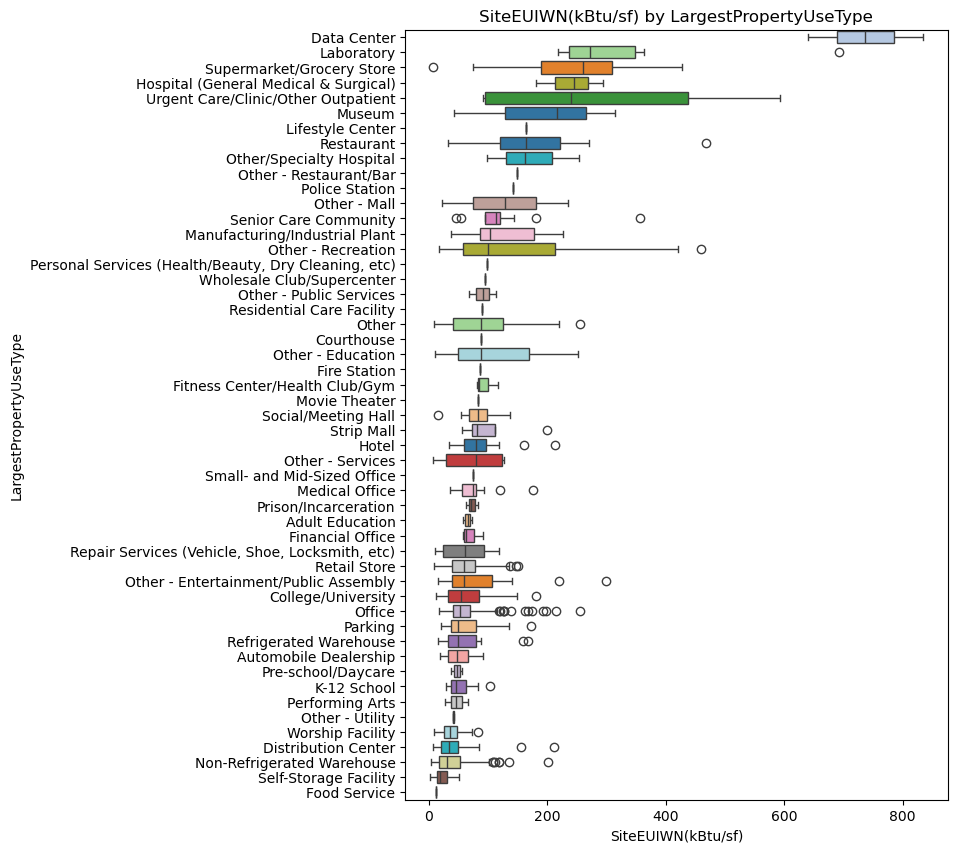

In [88]:
# Orderby median de SiteEnergyUseWN(kBtu)
order_energy = df.groupby('LargestPropertyUseType')['SiteEUIWN(kBtu/sf)'].median().sort_values(ascending=False).index
plt.figure(figsize=(7, 10))  # Ajustez la taille selon vos besoins
sns.boxplot(
    y='LargestPropertyUseType',
    x='SiteEUIWN(kBtu/sf)',
    data=df,
    orient='h',
    order=order_energy,
    palette="tab20",
    hue='LargestPropertyUseType'
)
plt.title('SiteEUIWN(kBtu/sf) by LargestPropertyUseType')
plt.xlabel('SiteEUIWN(kBtu/sf)')
plt.ylabel('LargestPropertyUseType')
plt.legend([],[], frameon=False)

In [89]:
def group_Type(type):
    # Data Center
    A = ['Data Center']
    # Laboratoires
    B = ['Laboratory']
    # Supermarche
    C = ['Supermarket/Grocery Store'] 
    # Hopital
    D = ['Other/Specialty Hospital', 'Hospital (General Medical & Surgical)', 'Urgent Care/Clinic/Other Outpatient']  
    # Public et loisirs
    E = ['Museum', 'Other - Recreation', 'Movie Theater', 'Fitness Center/Health Club/Gym', 'Performing Arts',
         'Other - Entertainment/Public Assembly', 'Social/Meeting Hall', 'Bar/Nightclub', 'Swimming Pool']
    # Restauration 
    F = ['Restaurant', 'Other - Restaurant/Bar', 'Fast Food Restaurant']
    # Commerces
    G = ['Strip Mall', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 
         'Retail Store', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Automobile Dealership', 'Library', 'Other - Mall', 
         'Lifestyle Center', 'Convenience Store without Gas Station', 'Food Sales']
    # Education
    H = ['Other - Education', 'College/University', 'Adult Education', 'Pre-school/Daycare', 'K-12 School', 'Vocational School'] 
    # Résidences
    I = ['Senior Care Community', 'Residential Care Facility', 'Hotel', 'Multifamily Housing', 'Other - Lodging/Residential', 
         'Residence Hall/Dormitory']    
    # Industrie et entrepôts
    J = ['Manufacturing/Industrial Plant', 'Refrigerated Warehouse', 'Distribution Center', 'Non-Refrigerated Warehouse', 
         'Self-Storage Facility']
    # Bureaux et services
    K = ['Other - Public Services', 'Financial Office', 'Medical Office', 'Bank Branch', 'Office', 'Other - Utility',
        'Courthouse', 'Fire Station', 'Prison/Incarceration', 'Worship Facility', 'Other - Services']
    # Parking
    L = ['Parking']
    # None
    M = ['None']

 
    if type in A:
        return 'DataCenter'
    elif type in B:
        return 'Laboratoire'
    elif type in C:
        return 'Supermarche'
    elif type in D:
        return 'Hopital'
    elif type in E:
        return 'Public_loisirs'
    elif type in F:
        return 'Restauration'
    elif type in G:
        return 'Commerces'
    elif type in H:
        return 'Education'
    elif type in I:
        return 'Résidences'
    elif type in J:
        return 'Industrie_entrepots'
    elif type in K:
        return 'Bureaux_services'
    elif type in L:
        return 'Parking'
    elif type in M:
        return 'None'
    else:
        return 'Autres'


In [90]:
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].apply(group_Type)
df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].apply(group_Type)
df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].apply(group_Type)

In [91]:
print(df['LargestPropertyUseType'].value_counts())

LargestPropertyUseType
Bureaux_services       326
Industrie_entrepots    252
Commerces               83
Autres                  62
Education               61
Résidences              56
Public_loisirs          56
Supermarche             29
Restauration            13
Hopital                 10
Parking                  9
Laboratoire              6
DataCenter               2
Name: count, dtype: int64


In [92]:
print(df['SecondLargestPropertyUseType'].value_counts())

SecondLargestPropertyUseType
None                   538
Bureaux_services       131
Parking                105
Commerces               47
Industrie_entrepots     31
Autres                  31
Public_loisirs          26
Restauration            23
Education                9
Résidences               9
DataCenter               7
Supermarche              5
Laboratoire              2
Hopital                  1
Name: count, dtype: int64


In [93]:
print(df['ThirdLargestPropertyUseType'].value_counts())

ThirdLargestPropertyUseType
None                   801
Bureaux_services        42
Commerces               23
Autres                  20
Parking                 15
Industrie_entrepots     14
Restauration            13
Public_loisirs          12
Education               10
Résidences               7
DataCenter               5
Laboratoire              1
Hopital                  1
Supermarche              1
Name: count, dtype: int64


### GFA

On vérifie si PropertyGFATotal est inférieur ou égale à la somme de tous les GFA (parking compris) .

In [94]:
def check_property_gfa(row):
    # Pas d'évaluation si PropertyGFATotal est nan
    if pd.isna(row['PropertyGFATotal']):
        return False
    
    # Initialiser total_gfa_sum avec PropertyGFAParking si ce n'est pas nan
    total_gfa_sum = row['PropertyGFAParking'] if pd.notna(row['PropertyGFAParking']) else 0
    
    # Ajouter LargestPropertyUseTypeGFA 
    if (row['LargestPropertyUseType'] != "Parking" ) or \
    (row['LargestPropertyUseType'] == "Parking" and (row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['LargestPropertyUseTypeGFA']
    
    # Ajouter SecondLargestPropertyUseTypeGFA 
    if (row['SecondLargestPropertyUseType'] != "Parking") or \
    (row['SecondLargestPropertyUseType'] == "Parking" and (row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0
    
    # Ajouter ThirdLargestPropertyUseTypeGFA
    if (row['ThirdLargestPropertyUseType'] != "Parking" ) or \
    (row['ThirdLargestPropertyUseType'] == "Parking" and (row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0

    # Calculer les marges de 5% pour plus ou moins
    lower_bound = total_gfa_sum * 0.95
    upper_bound = total_gfa_sum * 1.15
    
    # Vérifier si ThirdLargestPropertyUseType est None
    if row['ThirdLargestPropertyUseType'] != "None":
        # Si oui, vérifier seulement si PropertyGFATotal est inférieur au lower_bound
        return not (row['PropertyGFATotal'] >= lower_bound)
    else:
        # Sinon, vérifier si PropertyGFATotal est dans la marge de tolérance
        return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)


# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df['is_outlier'] = df.apply(check_property_gfa, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df[df['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 127


In [95]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PropertyGFAParking', 'PrimaryPropertyType', 'LargestPropertyUseTypeGFA', 
                 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]

,PropertyGFATotal,PropertyGFAParking,PrimaryPropertyType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
594,238148,0,Large Office,245240.0,Parking,5616.0,5616.0
3000,38879,11328,Other,38879.0,None,NaN,NaN
477,1380959,0,Large Office,1000730.0,Commerces,281296.0,220303.0
462,92792,0,Distribution Center,85343.0,Bureaux_services,13435.0,NaN
1470,26930,6350,Medical Office,26930.0,None,NaN,NaN
171,102796,12611,Senior Care Community,55259.0,Bureaux_services,40091.0,3231.0
976,39320,6960,Other,39320.0,None,NaN,NaN
3076,20535,0,Small- and Mid-Sized Office,13600.0,Industrie_entrepots,8200.0,NaN
1094,29392,3834,Small- and Mid-Sized Office,29392.0,Parking,3834.0,NaN
531,112896,0,Large Office,110746.0,Parking,57500.0,NaN


L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [96]:
# Supprimer les outliers du DataFrame
df = df[df['is_outlier'] == False]
df = df.drop(columns=['is_outlier'])

#### Completion à 0

In [97]:
# Fonction pour calculer la somme des GFA et comparer avec PropertyGFATotal
def adjust_gfa_values(row):
    # Calculer la somme des GFA, en remplaçant les NaN par 0
    gfa_sum = np.nansum([
        row.get('LargestPropertyUseTypeGFA', 0),
        row.get('SecondLargestPropertyUseTypeGFA', 0),
        row.get('ThirdLargestPropertyUseTypeGFA', 0),
        row.get('PropertyGFAParking', 0)
    ])
    
    # Calculer une marge de 5% pour PropertyGFATotal
    lower_bound = row['PropertyGFATotal'] * 0.95
    upper_bound = row['PropertyGFATotal'] * 1.05
    
    # Vérifier si la somme des GFA est dans la marge de 5% de PropertyGFATotal
    if lower_bound <= gfa_sum <= upper_bound:
        # Remplacer les NaN par 0 pour les colonnes spécifiées
        for col in ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'PropertyGFAParking']:
            if pd.isna(row[col]):
                row[col] = 0
    return row


In [98]:
# Appliquer la fonction adjust_gfa_values à chaque ligne
df = df.apply(adjust_gfa_values, axis=1)

#### Calcul

In [99]:
def fill_missing_types_and_calculate_gfa(row):
    largest_gfa = row['LargestPropertyUseTypeGFA']
    second_largest_gfa = row.get('SecondLargestPropertyUseTypeGFA', 0)  # Utilise 0 si non défini
    parking_gfa = row['PropertyGFAParking']
    third_gfa = row.get('ThirdLargestPropertyUseTypeGFA', 0)  # Utilise 0 si non défini
    
    # Pour SecondLargestPropertyUseType
    if row['SecondLargestPropertyUseType'] == 'None':
        gfa_diff = row['PropertyGFATotal'] - largest_gfa - parking_gfa
        if gfa_diff > 0:
            row['SecondLargestPropertyUseType'] = "Autres" 
            row['SecondLargestPropertyUseTypeGFA'] = gfa_diff
            second_largest_gfa = gfa_diff  # Mise à jour de second_largest_gfa
        else:
            row['SecondLargestPropertyUseTypeGFA'] = 0

    # Calcul pour ThirdLargestPropertyUseType
    if row['ThirdLargestPropertyUseType'] == 'None':
        third_gfa_diff = row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa
        if third_gfa_diff > 0:
            row['ThirdLargestPropertyUseType'] = "Autres" 
            row['ThirdLargestPropertyUseTypeGFA'] = third_gfa_diff
            third_gfa = third_gfa_diff  # Mise à jour de third_gfa
        else:
            row['ThirdLargestPropertyUseTypeGFA'] = 0

    # Vérification pour une différence restante après ThirdLargestPropertyUseType
    remaining_gfa_diff = row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa - third_gfa
    if remaining_gfa_diff > 0:
        row['FourthLargestPropertyUseType'] = "Autres" 
        row['FourthLargestPropertyUseTypeGFA'] = remaining_gfa_diff
    else:
        row['FourthLargestPropertyUseType'] = "None" 
        row['FourthLargestPropertyUseTypeGFA'] = 0
    

    return row


In [100]:
# Appliquer la fonction pour ajuster les valeurs de Type et calculer les GFA
df = df.apply(fill_missing_types_and_calculate_gfa, axis=1)

#### Feature engineering

In [101]:
# Extraire les types et leurs GFA respectifs
types_columns = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'FourthLargestPropertyUseType']
gfa_columns = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'FourthLargestPropertyUseTypeGFA']

# Applatir le tableau et identifier tous les types d'utilisation uniques pour préparer les nouvelles colonnes
types_uniques = pd.unique(df[types_columns].values.ravel('K'))

# Initialiser les nouvelles colonnes pour chaque type unique dans le DataFrame original
for type_unique in types_uniques:
    if type_unique and type_unique != 'None':  # Ignorer les valeurs nulles ou 'None'
        df[f'GFA_{type_unique}'] = 0.0

# Parcourir chaque ligne et assigner les valeurs de GFA aux nouvelles colonnes
for index, row in df.iterrows():
    for type_col, gfa_col in zip(types_columns, gfa_columns):
        type_value = row[type_col]
        gfa_value = row[gfa_col]
        if type_value and type_value != 'None':  # S'assurer que le type est valide
            df.at[index, f'GFA_{type_value}'] += gfa_value

In [102]:
df.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),Electricity(kWh),NaturalGas(therms),Comments,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,FourthLargestPropertyUseType,FourthLargestPropertyUseTypeGFA,GFA_Résidences,GFA_Public_loisirs,GFA_Bureaux_services,GFA_Autres,GFA_Education,GFA_Commerces,GFA_Industrie_entrepots,GFA_Hopital,GFA_Restauration,GFA_DataCenter,GFA_Supermarche,GFA_Laboratoire,GFA_Parking
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,0,88434,Résidences,88434.0,None,0.0,None,0.0,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,1.156514e+06,12764.529300,NaN,NaN,249.98,2.83,89,1,26.872820,52.917723,17.117720,None,0.0,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,0,61320,Résidences,61320.0,None,0.0,None,0.0,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,8.115253e+05,18112.130860,NaN,NaN,286.43,4.67,90,1,31.877211,39.858983,26.072621,None,0.0,61320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10,2016,NonResidential,Hotel,Camlin,1619 9th Avenue,Seattle,WA,98101.0,0660000825,7,DOWNTOWN,47.61390,-122.33283,1.0,11,83008,0,83008,Résidences,81352.0,Autres,1656.0,None,0.0,NaN,27.0,70.800003,74.500000,146.600006,154.699997,5758795.0,6062767.5,8.239199e+05,29475.800780,NaN,NaN,176.14,2.12,90,1,0.000000,46.368511,48.617731,None,0.0,81352.0,0.0,0.0,1656.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,11,2016,NonResidential,Other,Paramount Theatre,911 Pine St,Seattle,WA,98101.0,0660000955,7,DOWNTOWN,47.61327,-122.33136,1.0,8,102761,0,102761,Public_loisirs,102761.0,None,0.0,None,0.0,NaN,NaN,61.299999,68.800003,141.699997,152.300003,6298131.5,7067881.5,1.065843e+06,3851.890137,NaN,NaN,221.51,2.16,90,1,32.206065,51.453254,5.449851,None,0.0,0.0,102761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,12,2016,NonResidential,Hotel,311wh-Pioneer Square,612 2nd Ave,Seattle,WA,98104.0,0939000080,7,DOWNTOWN,47.60294,-122.33263,1.0,15,163984,0,163984,Résidences,163984.0,None,0.0,None,0.0,NaN,43.0,83.699997,86.599998,180.899994,187.199997,13723820.0,14194054.0,2.138898e+06,64259.000000,NaN,NaN,392.16,2.39,112,1,0.000000,51.415325,45.271774,None,0.0,163984.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Regroupement des GFAParking

In [103]:
def unify_parking_gfa(row):
    gfa_parking = row['GFA_Parking']
    property_gfa_parking = row['PropertyGFAParking']
    
    if gfa_parking == 0:
        return property_gfa_parking
    if property_gfa_parking == 0 or property_gfa_parking == gfa_parking:
        return gfa_parking

    # Somme des GFA_"
    new_gfa_columns = [col for col in df.columns if col.startswith('GFA_')]
    new_gfa_sum = sum(row[col] for col in new_gfa_columns if pd.notnull(row[col]))

    if np.isclose(row['PropertyGFATotal'], new_gfa_sum, rtol=0.05):
       return gfa_parking
    elif np.isclose((row['PropertyGFATotal'] - new_gfa_sum), property_gfa_parking, rtol=0.05):
        return (gfa_parking + property_gfa_parking)
    else:
        return property_gfa_parking

# Appliquer la fonction et mettre à jour la colonne GFA_Parking
df['GFA_Parking'] = df.apply(unify_parking_gfa, axis=1)


In [104]:
def check_gfa_sums(df):
    # Identifier dynamiquement les colonnes commençant par "GFA_"
    new_gfa_columns = [col for col in df.columns if col.startswith('GFA_')]
    
    # Initialiser une liste pour stocker les indices des lignes avec des incohérences
    mismatched_rows = []
    
    # Parcourir le DataFrame
    for index, row in df.iterrows():
        # Calculer la somme des nouvelles colonnes de GFA
        new_gfa_sum = sum(row[col] for col in new_gfa_columns if pd.notnull(row[col]))
        
        # Vérifier si les sommes correspondent
        if not np.isclose(row['PropertyGFATotal'], new_gfa_sum, rtol=0.05):  
            mismatched_rows.append(index)
    
    # Retourner les indices des lignes avec des incohérences
    return mismatched_rows

# Utiliser la fonction sur votre DataFrame
mismatched_rows = check_gfa_sums(df)

if mismatched_rows:
    print(f"Incohérences trouvées aux lignes : {mismatched_rows}")
    display(df.loc[mismatched_rows])
else:
    print("Toutes les sommes de GFA sont cohérentes.")

Toutes les sommes de GFA sont cohérentes.


## Résultats du nettoyage

Maintenant que le traitement des valeurs abérrantes et manquante a été fait, on peut supprimer les colonnes qui ne nous servirons pas pour nos modèles.

In [105]:
cols_to_drop = ['OSEBuildingID', 'DataYear', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State',
                'ZipCode', 'CouncilDistrictCode', 'TaxParcelIdentificationNumber', 'YearsENERGYSTARCertified', 'Comments',
                'Latitude', 'Longitude', 'Electricity(kWh)', 'NaturalGas(therms)', 'Outlier', 'PropertyGFAParking',
                'SiteEUI(kBtu/sf)', 'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'FourthLargestPropertyUseType', 
                'FourthLargestPropertyUseTypeGFA', 'PropertyGFATotal']

df_selected = df.drop(columns=cols_to_drop).copy()

In [106]:
df_selected.shape

(838, 27)

In [107]:
missing_values_count = df_selected.isnull().sum()
total_cells = np.product(df_selected.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 1.43 %


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

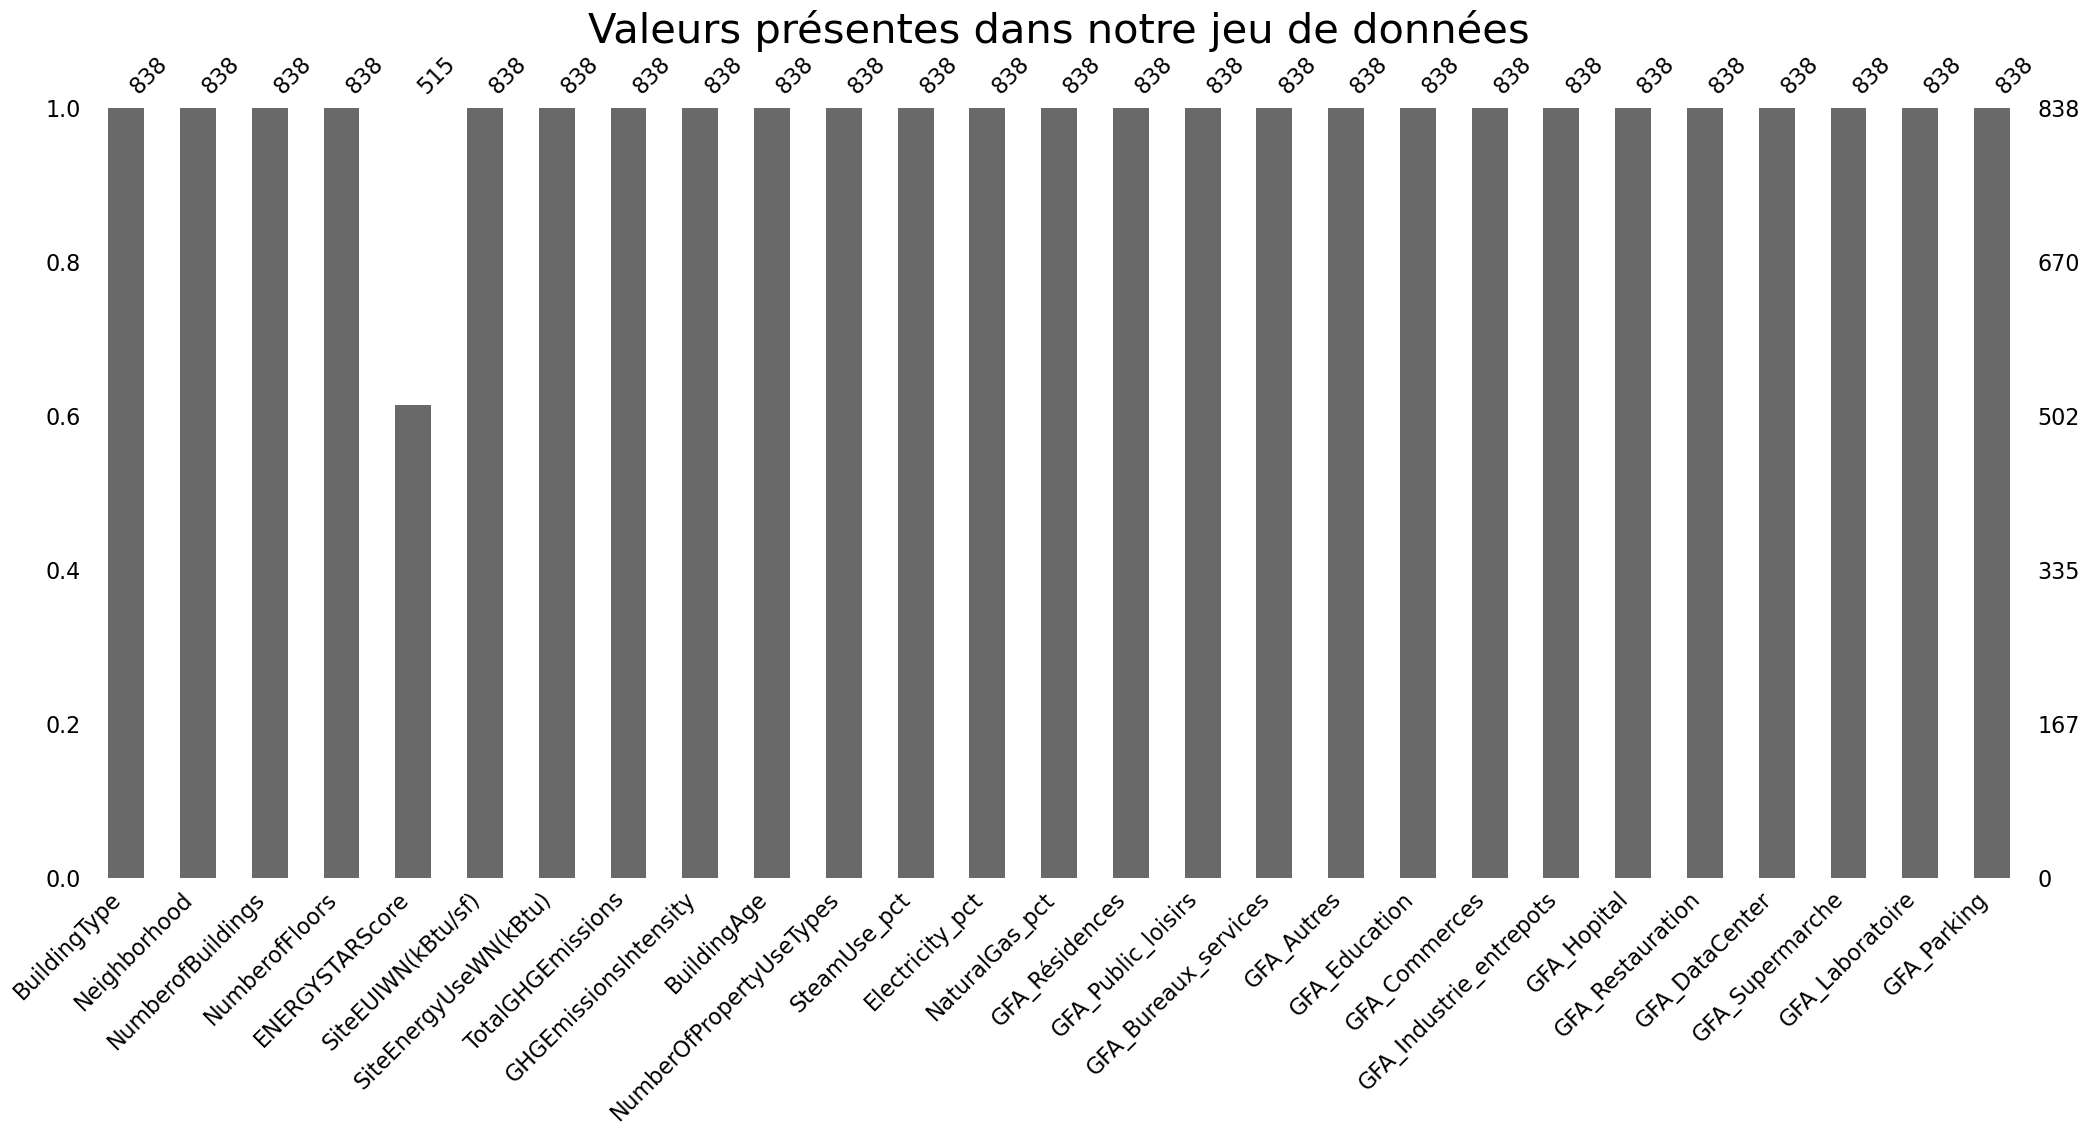

In [108]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_selected)

# Analyse Exploratoire des Données

## Analyse Univariée

### Variables numériques

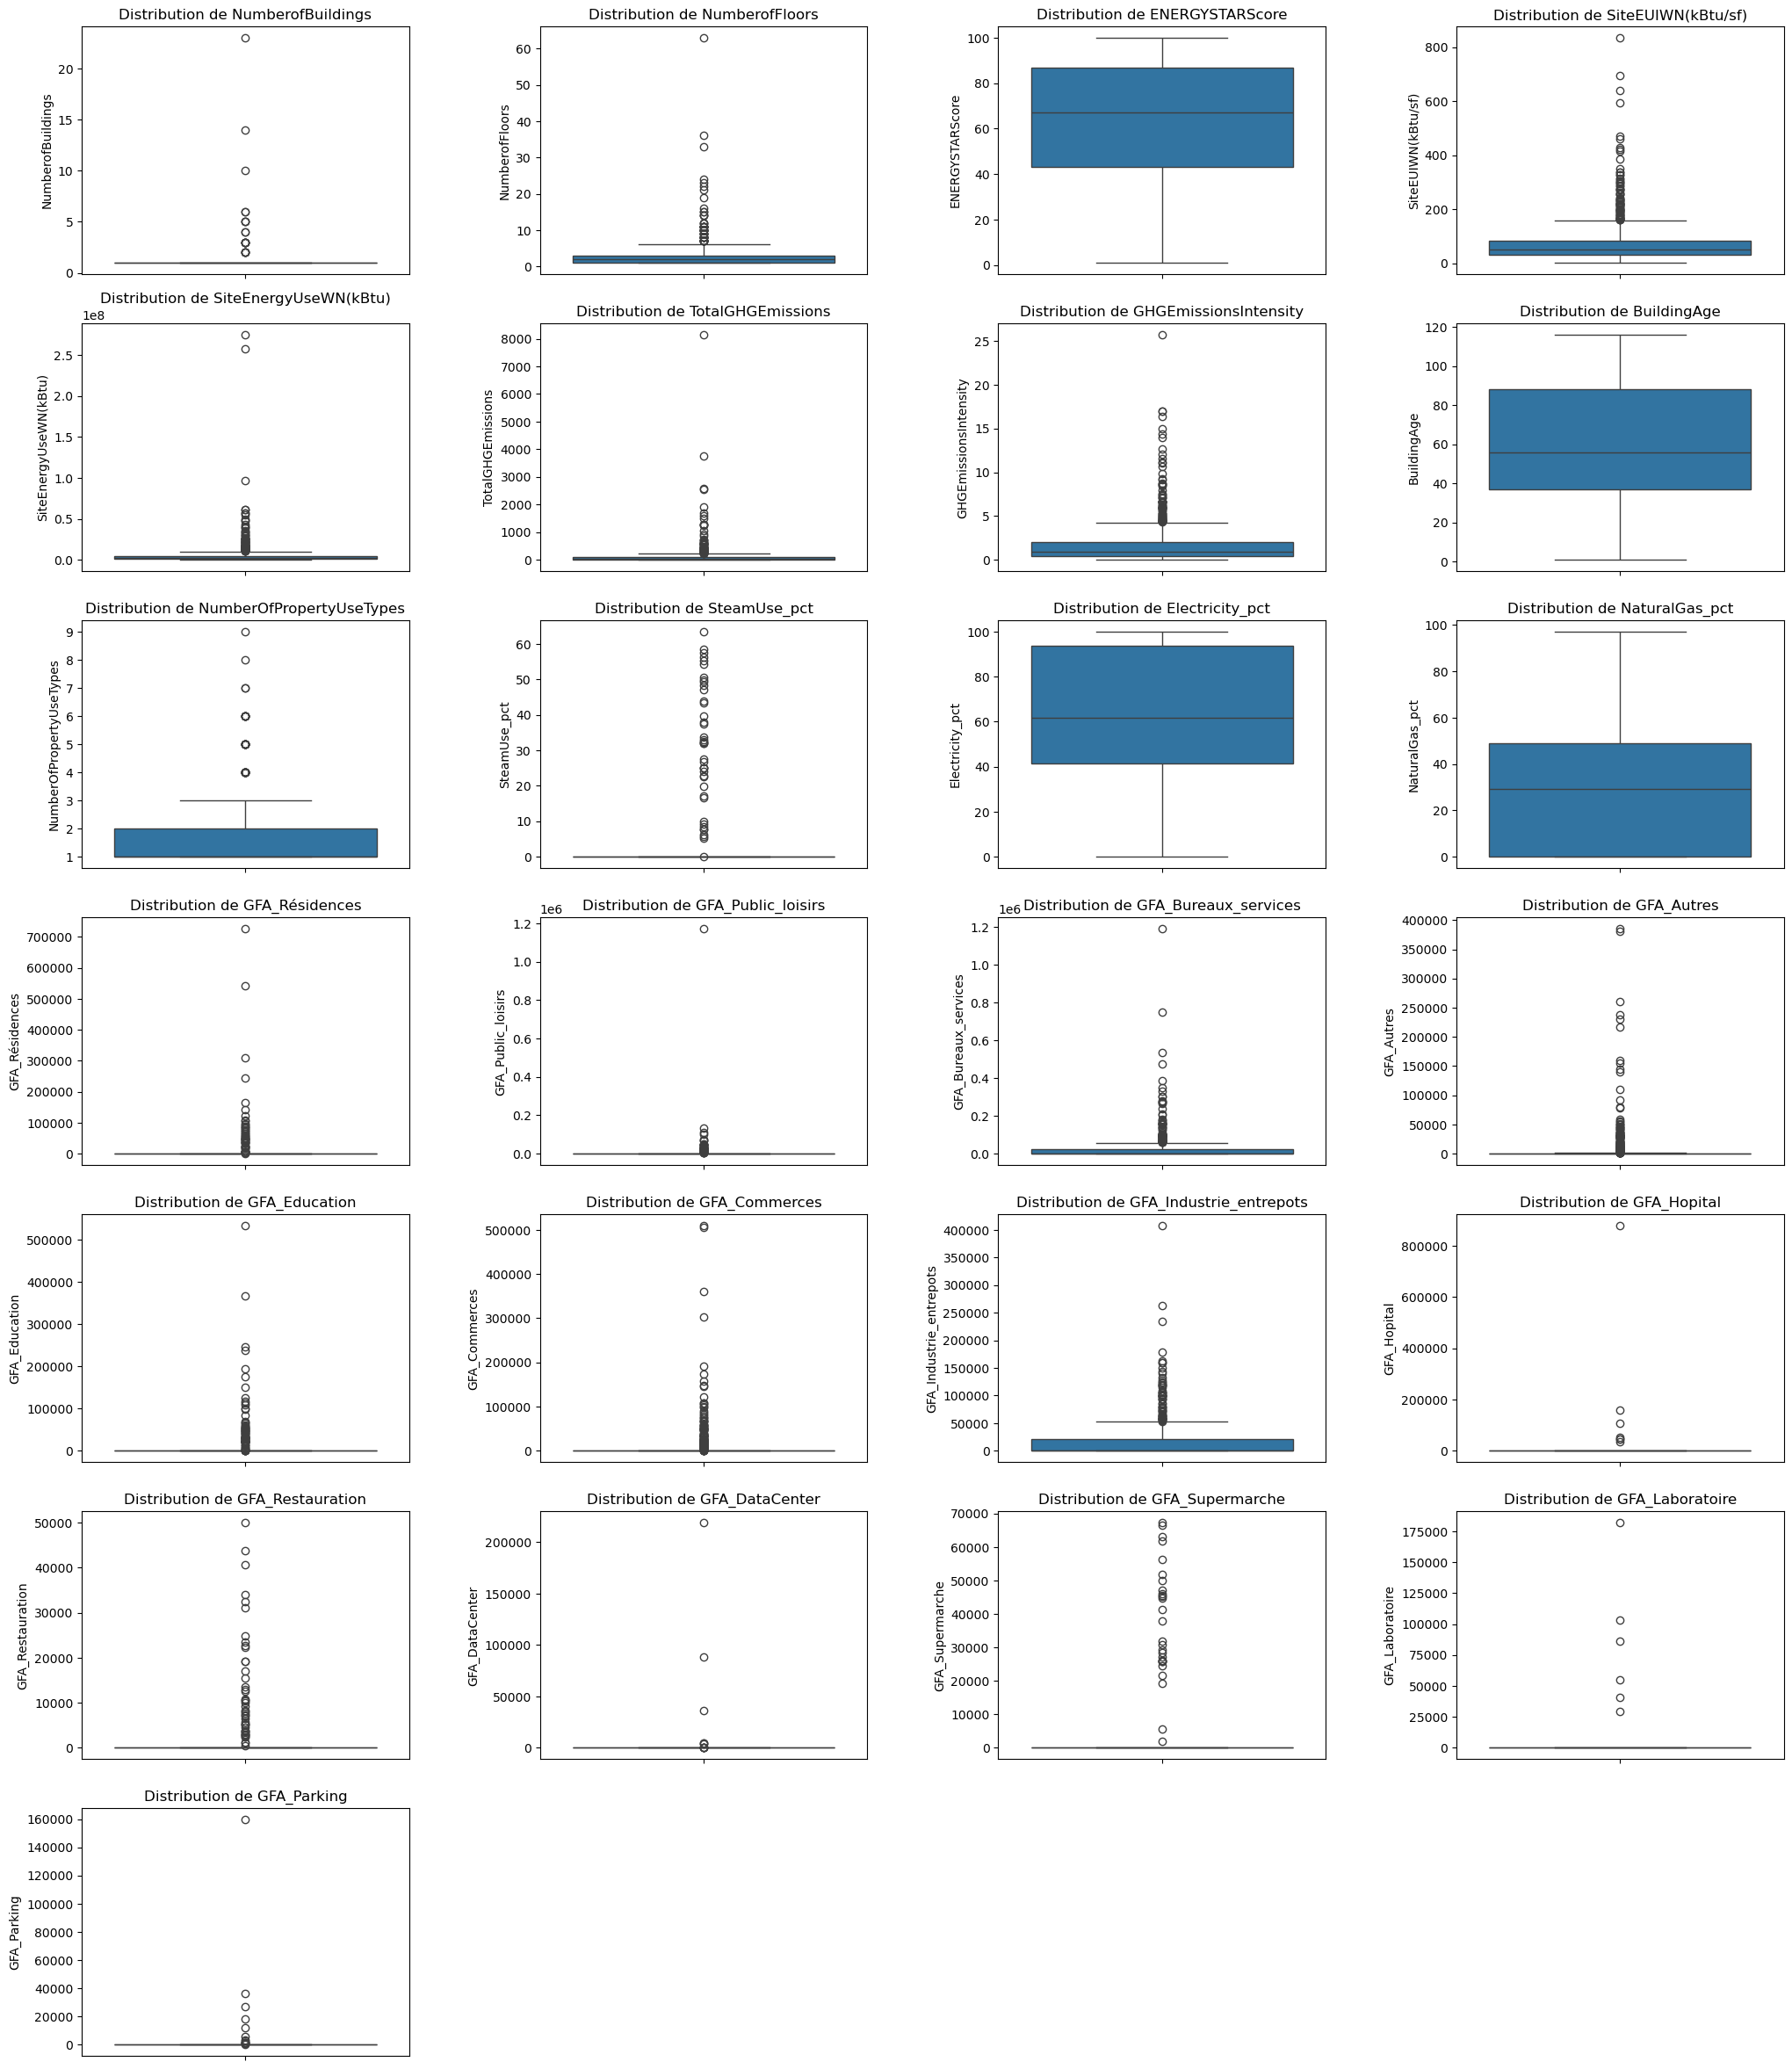

In [109]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df_selected.select_dtypes(include=['number'])

# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(25,30))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df_selected[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 28):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [110]:
df_selected.describe()

,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,NumberOfPropertyUseTypes,SteamUse_pct,Electricity_pct,NaturalGas_pct,GFA_Résidences,GFA_Public_loisirs,GFA_Bureaux_services,GFA_Autres,GFA_Education,GFA_Commerces,GFA_Industrie_entrepots,GFA_Hopital,GFA_Restauration,GFA_DataCenter,GFA_Supermarche,GFA_Laboratoire,GFA_Parking
count,838.000000,838.000000,515.000000,838.000000,8.380000e+02,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,8.380000e+02,8.380000e+02,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000
mean,1.106205,2.813842,61.555340,72.738664,5.379477e+06,119.817470,1.682804,59.914081,1.692124,1.552957,63.961952,28.800268,5045.619332,3.627148e+03,2.283721e+04,5851.079356,5239.417661,7404.189976,14397.813842,1580.151551,705.128878,427.606205,1281.830549,592.307876,326.113365
std,1.019258,3.749466,29.274867,78.312228,1.520100e+07,376.302935,2.327719,30.503889,1.090070,7.803385,27.436280,24.246054,37040.132310,4.169768e+04,6.905952e+04,28430.182394,30129.136033,35056.505757,32314.681631,31212.807338,4074.637859,8249.897307,7452.153773,8210.159421,5784.258913
min,1.000000,1.000000,1.000000,1.500000,5.811420e+04,0.400000,0.010000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,43.000000,31.299999,1.072144e+06,17.327500,0.412500,37.000000,1.000000,0.000000,41.276430,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,67.000000,51.400000,2.074731e+06,41.785000,0.940000,56.000000,1.000000,0.000000,61.667930,29.196052,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,87.000000,82.149998,4.754826e+06,101.477500,1.980000,88.000000,2.000000,0.000000,93.699763,49.078968,0.000000,0.000000e+00,2.294600e+04,722.250000,0.000000,0.000000,21317.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23.000000,63.000000,100.000000,834.400024,2.747260e+08,8145.520000,25.710000,116.000000,9.000000,63.453768,100.000000,97.077764,726000.000000,1.172127e+06,1.191115e+06,385274.000000,533826.000000,509342.000000,407491.000000,879000.000000,50000.000000,218997.000000,67263.000000,181930.000000,159599.000000


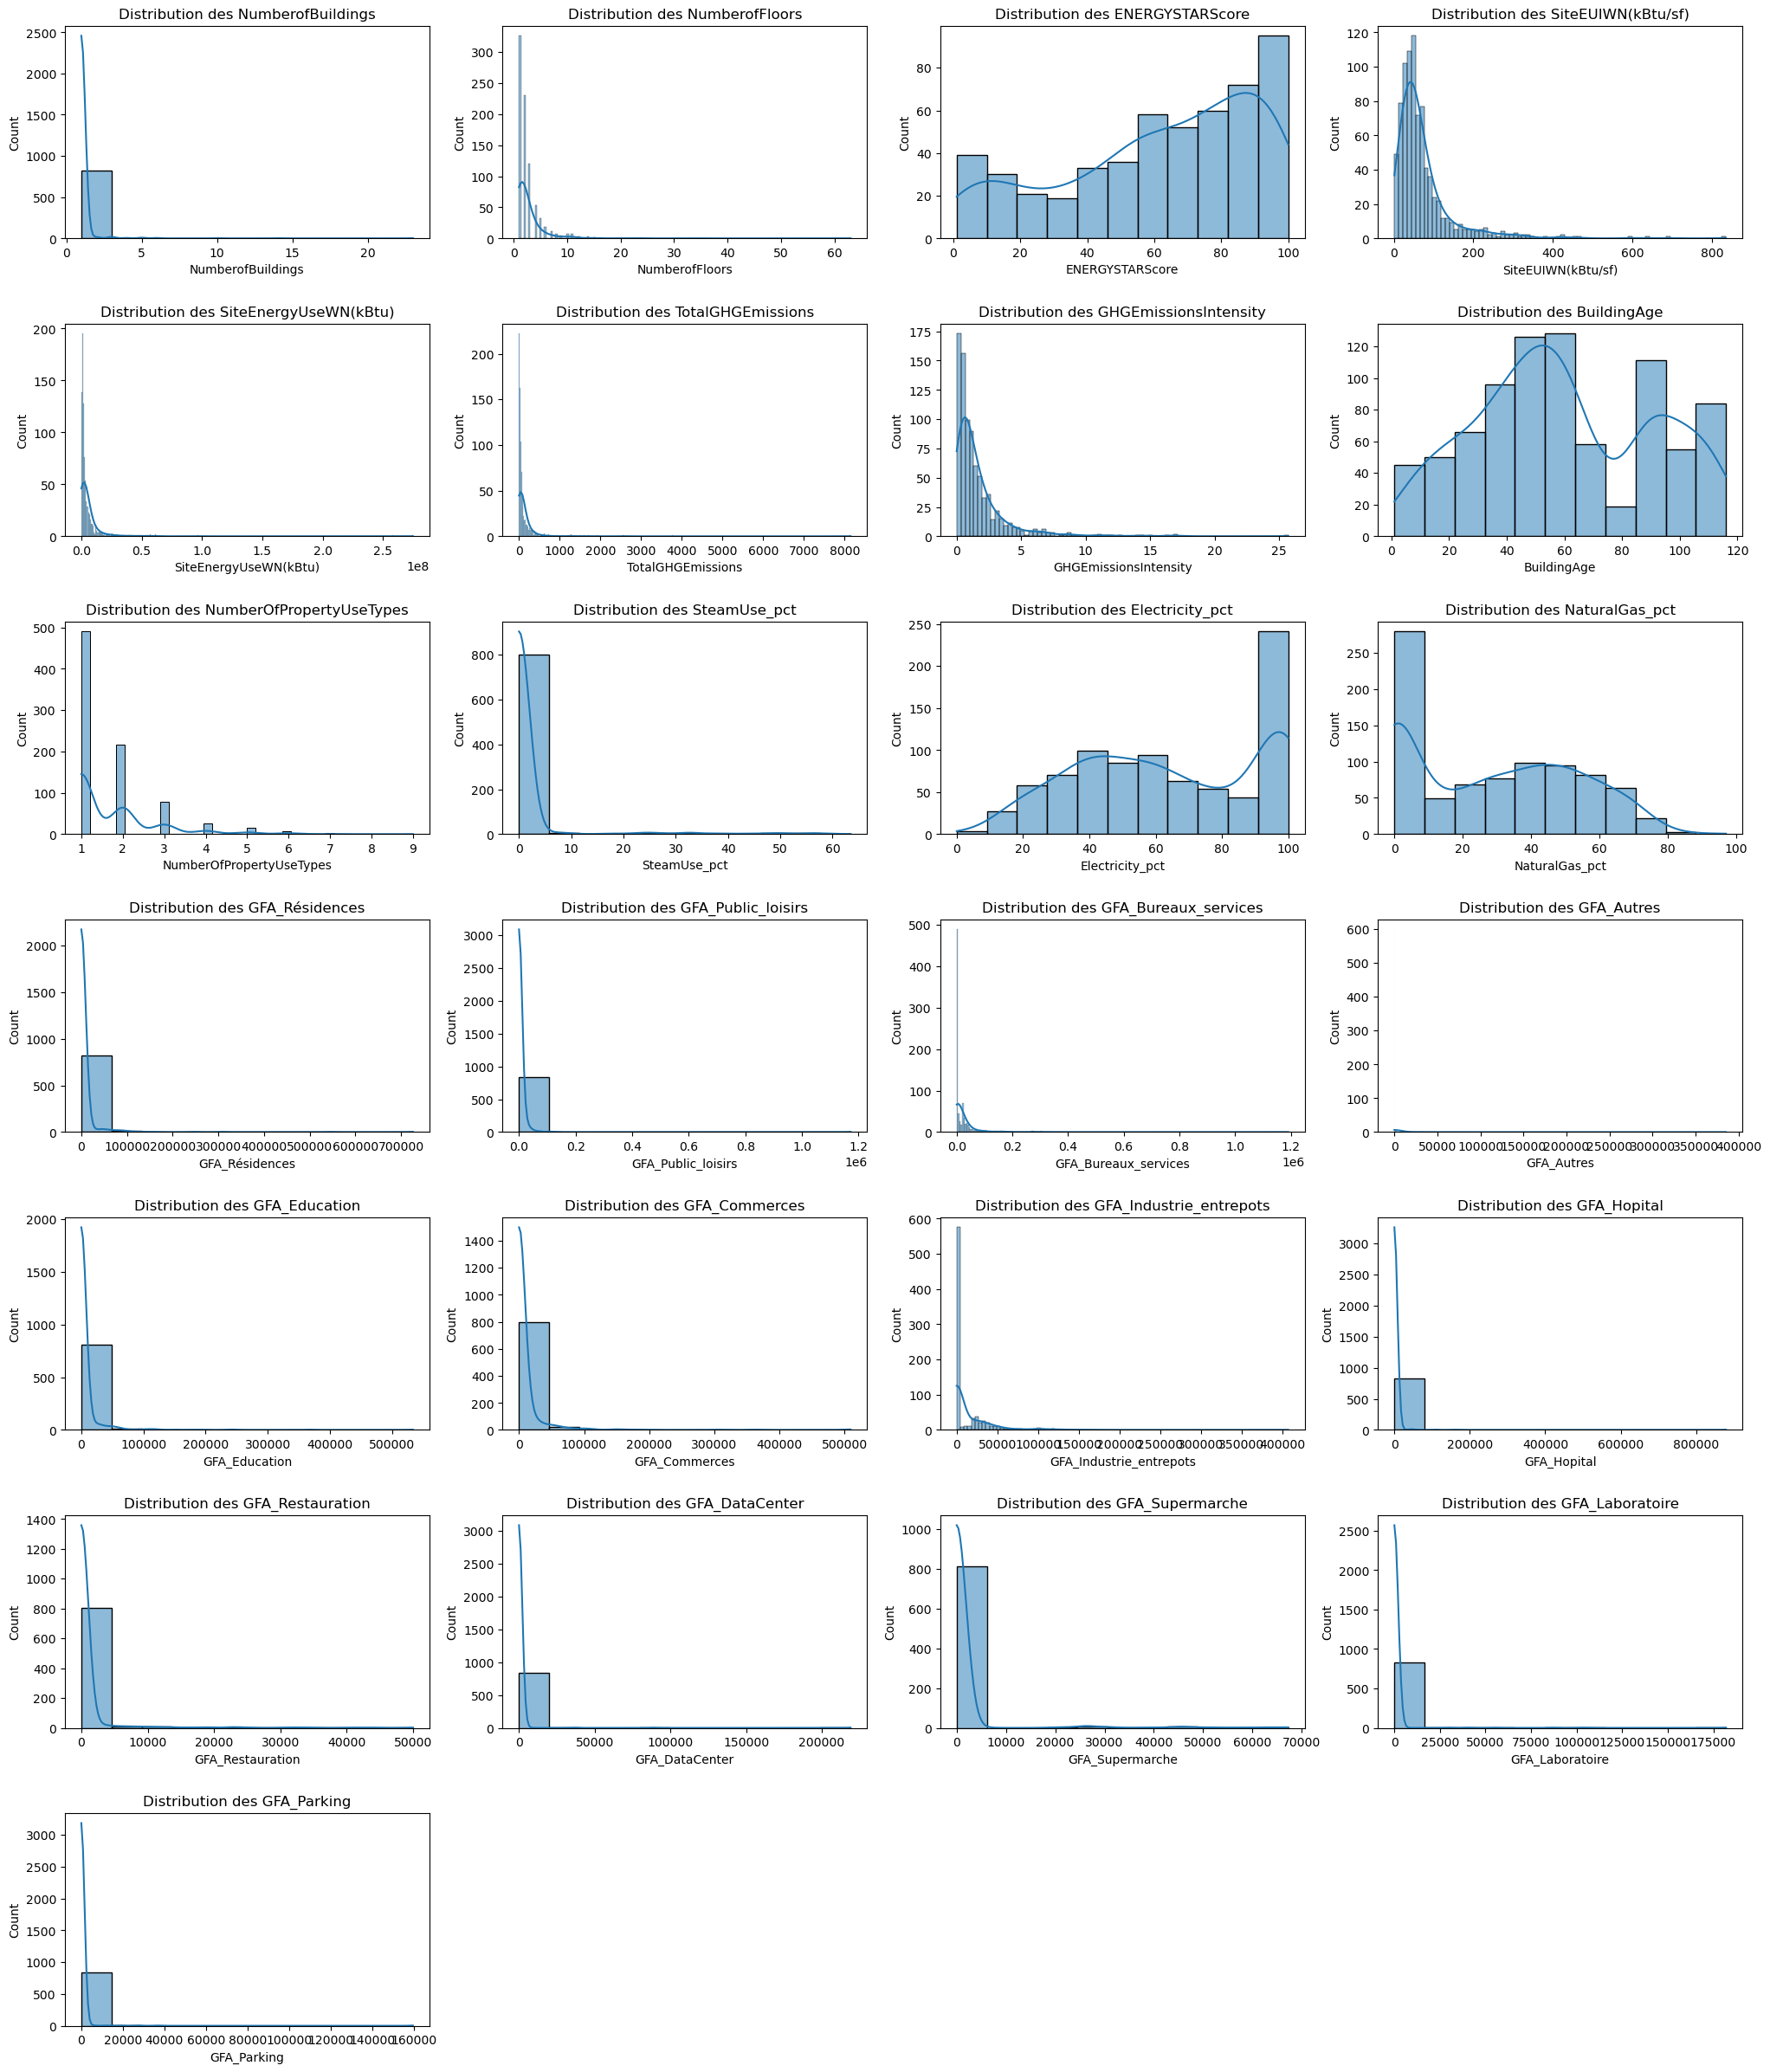

In [111]:
# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(25,30))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

# Density plot
for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.histplot(data=df_selected, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution des {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 28):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [112]:
# Compter le nombre de valeurs zéro ou négatives dans 'TotalGHGEmissions'
count_zero_neg_ghg = len(df_selected[df_selected['TotalGHGEmissions'] <= 0])

# Compter le nombre de valeurs zéro ou négatives dans 'SiteEnergyUse(kBtu)'
count_zero_neg_energy = len(df_selected[df_selected['SiteEnergyUseWN(kBtu)'] <= 0])

# Afficher les résultats
print(f"Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': {count_zero_neg_ghg}")
print(f"Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': {count_zero_neg_energy}")

Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': 0
Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': 0


In [113]:
# Calculer le logarithme des colonnes 'TotalGHGEmissions' et 'SiteEnergyUseWN(kBtu)'
df_selected = df_selected.copy()
df_selected['Log_TotalGHGEmissions'] = np.log(df_selected['TotalGHGEmissions'])
df_selected['Log_SiteEnergyUseWN'] = np.log(df_selected['SiteEnergyUseWN(kBtu)'])

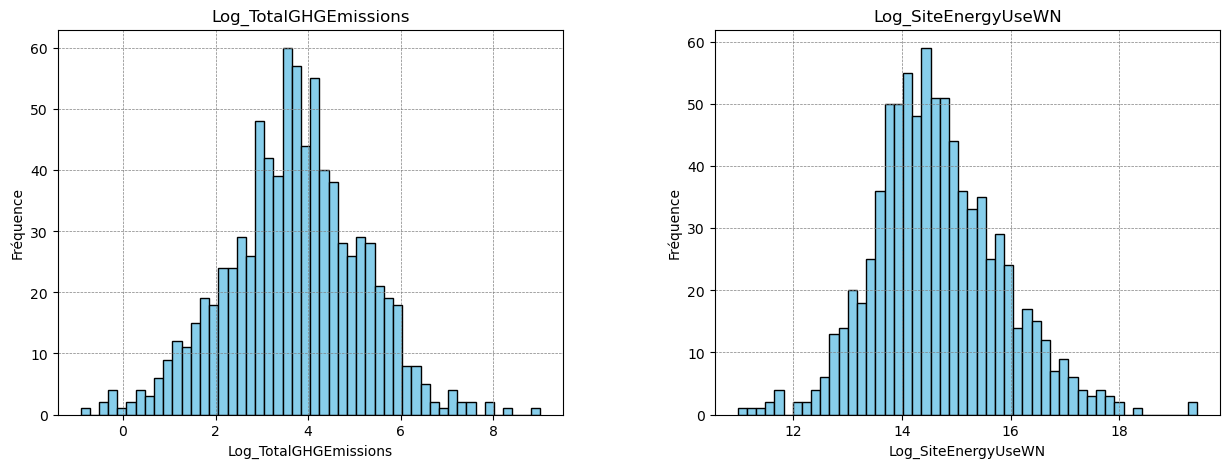

In [114]:
# Créez un histogramme pour TotalGHGEmissions et SiteEnergyUse(kBtu)
# Sélection des colonnes spécifiques
selected_columns = df_selected[['Log_TotalGHGEmissions','Log_SiteEnergyUseWN']]

# Créez un histogramme pour chaque variable numérique sélectionnée
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, column in zip(axes, selected_columns.columns):
    ax.hist(df_selected[column], bins=50, edgecolor='black', color='skyblue')
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Fréquence')
    # Ajouter un quadrillage
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
    
# Ajustez l'espace entre les subplots
plt.subplots_adjust(wspace=0.3)

# Affichez les histogrammes
plt.show()

### Variables catégorielles

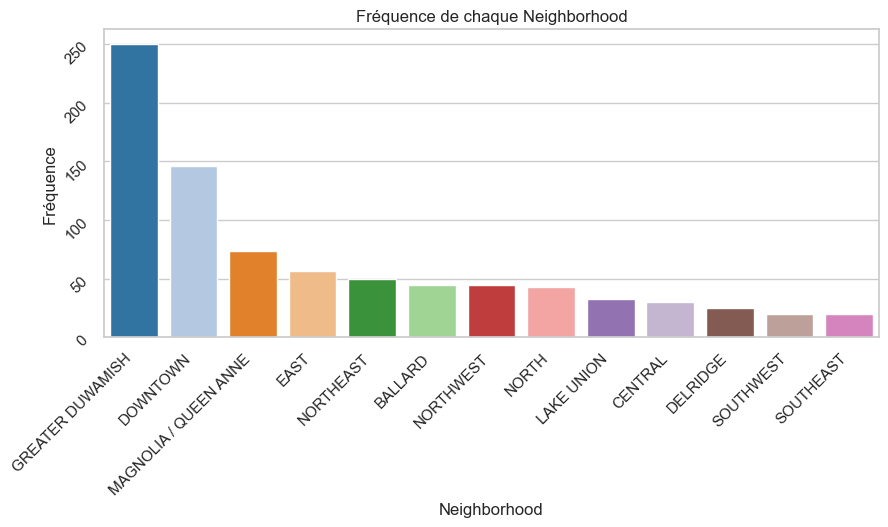

In [115]:
# Compter le nombre d'occurrences pour chaque Neighborhood
group_counts = df_selected['Neighborhood'].value_counts().reset_index()
group_counts.columns = ['Neighborhood', 'Counts']

plt.figure(figsize=(10, 4))
sns.set(style="whitegrid")

# Créer un graphique à barres
sns.barplot(x='Neighborhood', y='Counts', data=group_counts, hue='Neighborhood', palette="tab20", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque Neighborhood')
plt.ylabel('Fréquence')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45, ha="right")

plt.show()

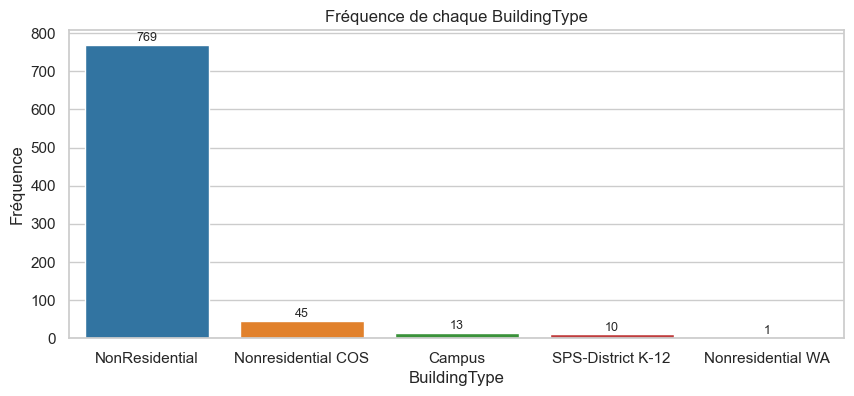

In [116]:
# Compter le nombre d'occurrences pour chaque BuildingType
group_counts = df_selected['BuildingType'].value_counts().reset_index()
group_counts.columns = ['BuildingType', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
barplot = sns.barplot(x='BuildingType', y='Counts', data=group_counts, hue='BuildingType', palette="tab10", legend=False)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque BuildingType')
plt.ylabel('Fréquence')
plt.xlabel('BuildingType')

# Itérer sur les barres pour afficher le nombre d'occurrences
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     size=9, xytext = (0, 5), 
                     textcoords = 'offset points')

plt.show()

La distribution des catégories est largement  déséquilibrée cce qui peut influencer la performance de nos modèles de ML, car les modèles pourraient être biaisés en faveur de la classe majoritaire. Il vaut mieux ne pas la considérer dans nos modèles et la supprimer.

In [117]:
df_selected = df_selected.drop(columns=['BuildingType'])

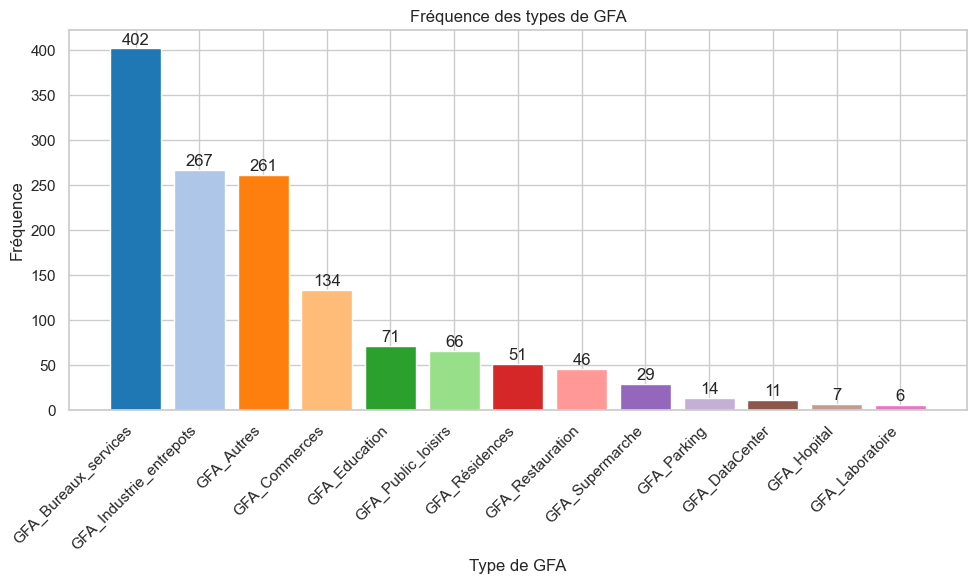

In [118]:
# Calculer la fréquence des valeurs non nulles pour chaque GFA
gfa_columns = [col for col in df.columns if col.startswith('GFA_')]
 
gfa_frequencies = {col: (df_selected[col] > 0).sum() for col in gfa_columns}

# série décroissante
gfa_frequencies_series = pd.Series(gfa_frequencies).sort_values(ascending=False)

# Créer le bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(gfa_frequencies_series.index, gfa_frequencies_series.values, color=plt.cm.tab20(range(len(gfa_frequencies_series))))

# Ajouter le nombre en haut de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.title('Fréquence des types de GFA')
plt.xlabel('Type de GFA')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Analyse Bivariée

### Variables numériques

In [119]:
# Normalisation des données
scaler = StandardScaler()

df_normalized = df_selected.copy()

# Sélectionner uniquement les colonnes numériques
numerics_col = df_selected.select_dtypes(include=['number']).columns

# Appliquez la normalisation min-max aux données
df_normalized[numerics_col] = scaler.fit_transform(df_selected[numerics_col])

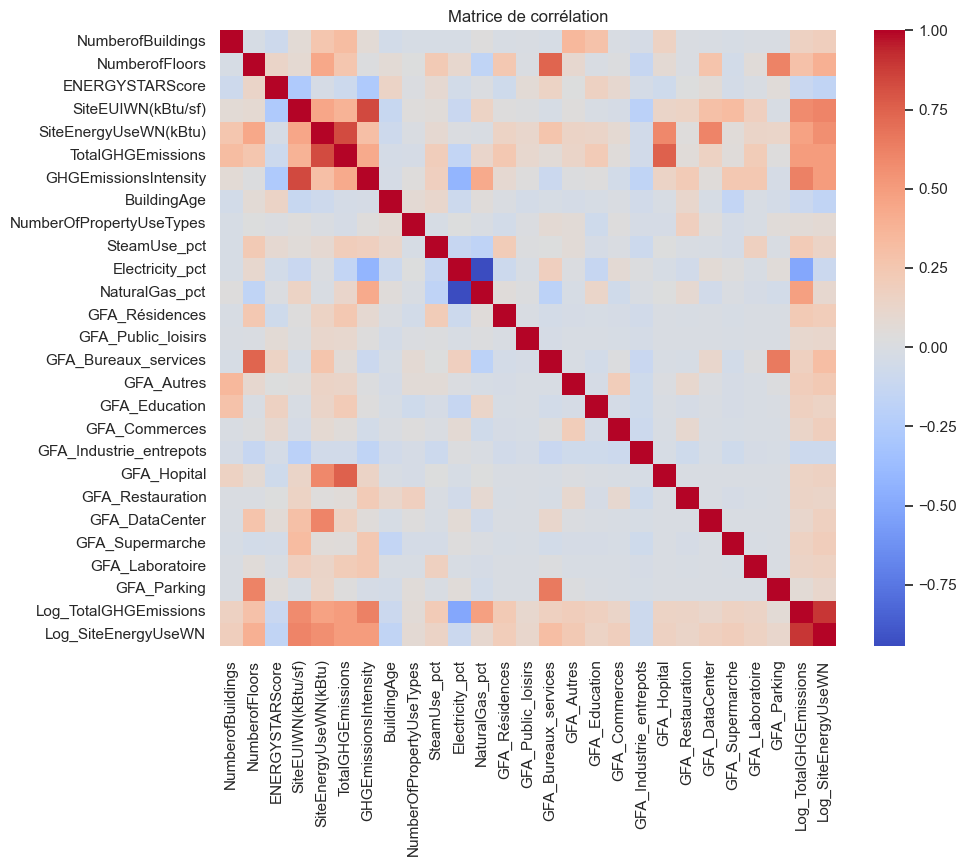

In [120]:
# Calcul de la matrice de corrélation
corr_matrix = df_normalized[numerics_col].corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

### Variables catégorielles

In [121]:
def plot_boxplots_by_category(df, category):
    sns.set(style="whitegrid")
    

    # Lignes en fonction du nombre de catégories
    num_categories = len(df[category].unique())
    height_per_subplot = 3
    total_height = (num_categories * height_per_subplot) / 10

    # 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, total_height), constrained_layout=True)
    axes = axes.flatten()

    # Orderby median de SiteEnergyUseWN(kBtu)
    order_energy = df.groupby(category)['SiteEUIWN(kBtu/sf)'].median().sort_values(ascending=False).index
    # SiteEnergyUseWN(kBtu) boxplot
    sns.boxplot(y=category, x='SiteEUIWN(kBtu/sf)', data=df, orient='h', ax=axes[0], order=order_energy, hue=category, palette="tab20")
    axes[0].set_title(f'SiteEUIWN(kBtu/sf) by {category}')
    axes[0].set_xlabel('SiteEUIWN(kBtu/sf)')
    axes[0].set_ylabel(category)

    # Orderby median de  TotalGHGEmissions
    order_ghg = df.groupby(category)['GHGEmissionsIntensity'].median().sort_values(ascending=False).index
    # TotalGHGEmissions boxplot
    sns.boxplot(y=category, x='GHGEmissionsIntensity', data=df, orient='h', ax=axes[1], order=order_ghg, hue=category, palette="tab20")
    axes[1].set_title(f'GHGEmissionsIntensity by {category}')
    axes[1].set_xlabel('GHGEmissionsIntensity')
    axes[1].set_ylabel('')

    #plt.tight_layout()
    plt.show()

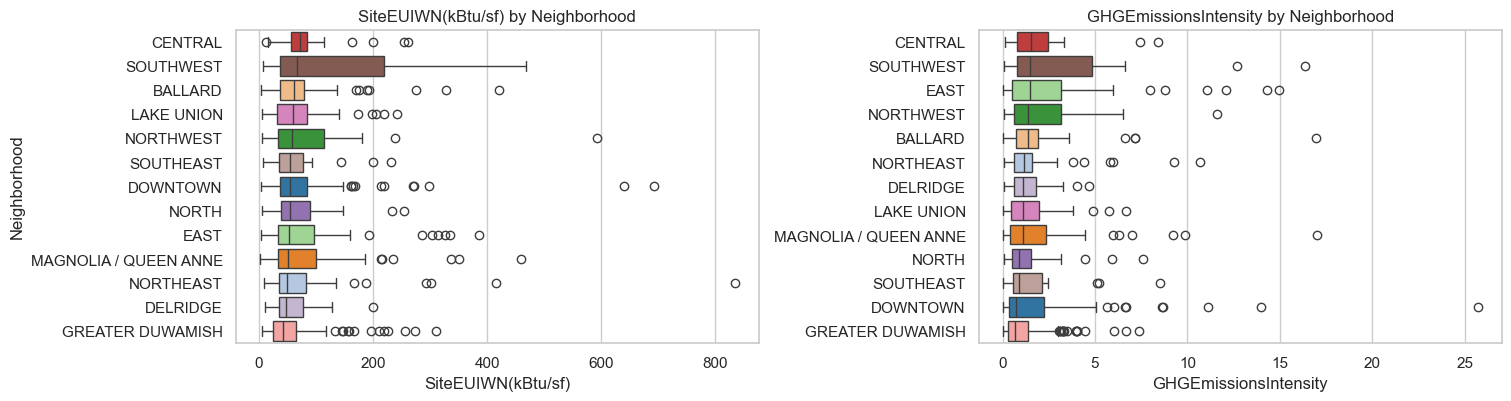

In [123]:
categorical_columns = ['Neighborhood']
for category in categorical_columns:
    plot_boxplots_by_category(df_selected, category)

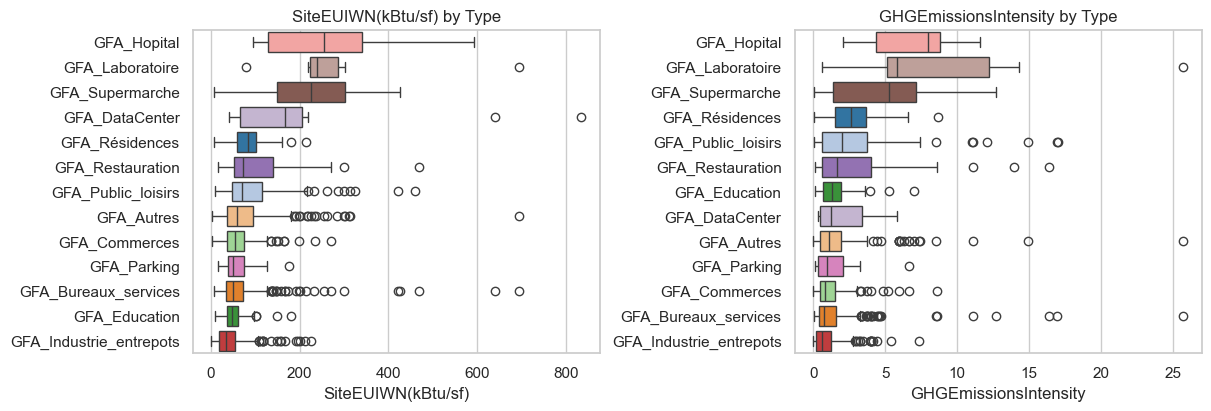

In [124]:
# Créer un dictionnaire de couleurs pour les colonnes GFA_xxx
tab20_colors = plt.cm.tab20.colors
colors = {col: tab20_colors[i] for i, col in enumerate(gfa_columns)}

data_propertyUse = []

# Ajouter les données de chaque GFA_xxx dans la liste
for gfa_type in gfa_columns:
    for index, row in df_selected.iterrows():
        if row[gfa_type] > 0:  # Si le GFA est non nul pour le type
            data_propertyUse.append({
                'Type': gfa_type,
                'SiteEUIWN(kBtu/sf)': row['SiteEUIWN(kBtu/sf)'],
                'GHGEmissionsIntensity': row['GHGEmissionsIntensity']
            })

# Convertir en DataFrame
df_propertyUse = pd.DataFrame(data_propertyUse)

# Calculer l'ordre des médianes pour chaque type
order_energy = df_propertyUse.groupby('Type')['SiteEUIWN(kBtu/sf)'].median().sort_values(ascending=False).index
order_ghg = df_propertyUse.groupby('Type')['GHGEmissionsIntensity'].median().sort_values(ascending=False).index

# Créer les graphiques
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), constrained_layout=True)
axes = axes.flatten()
sns.boxplot(y='Type', x='SiteEUIWN(kBtu/sf)', data=df_propertyUse, ax=axes[0], palette=colors, order=order_energy, hue='Type')
axes[0].set_title('SiteEUIWN(kBtu/sf) by Type')
axes[0].set_ylabel('')
axes[0].set_xlabel('SiteEUIWN(kBtu/sf)')

sns.boxplot(y='Type', x='GHGEmissionsIntensity', data=df_propertyUse, ax=axes[1], palette=colors, order=order_ghg, hue='Type')
axes[1].set_title('GHGEmissionsIntensity by Type')
axes[1].set_ylabel('')
axes[1].set_xlabel('GHGEmissionsIntensity')

plt.show()

## Analyse Multivariée (ANOVA)

In [125]:
def perform_anova_tukey(df, numeric_var, categorical_var):
    # Effectuez l'ANOVA
    formula = f"{numeric_var} ~ C({categorical_var})"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Effectuez le test de Tukey pour les comparaisons post-hoc
    tukey_result = pairwise_tukeyhsd(endog=df[numeric_var], groups=df[categorical_var], alpha=0.05)
    
    # Affichez les résultats
    print(f"ANOVA Table for {numeric_var} by {categorical_var}:")
    print(anova_table)
    print("\n")
    print(f"\nTukey's HSD Results for {numeric_var} by {categorical_var}:")
    print(tukey_result)

In [126]:
# Renommer la colonne pour ne pas avoir de probleme avec les caracteres spéciaux
df_selected.rename(columns={'SiteEUIWN(kBtu/sf)': 'SiteEUIWN_kBtu_sf'}, inplace=True)
df_propertyUse.rename(columns={'SiteEUIWN(kBtu/sf)': 'SiteEUIWN_kBtu_sf'}, inplace=True)

### Neighborhood

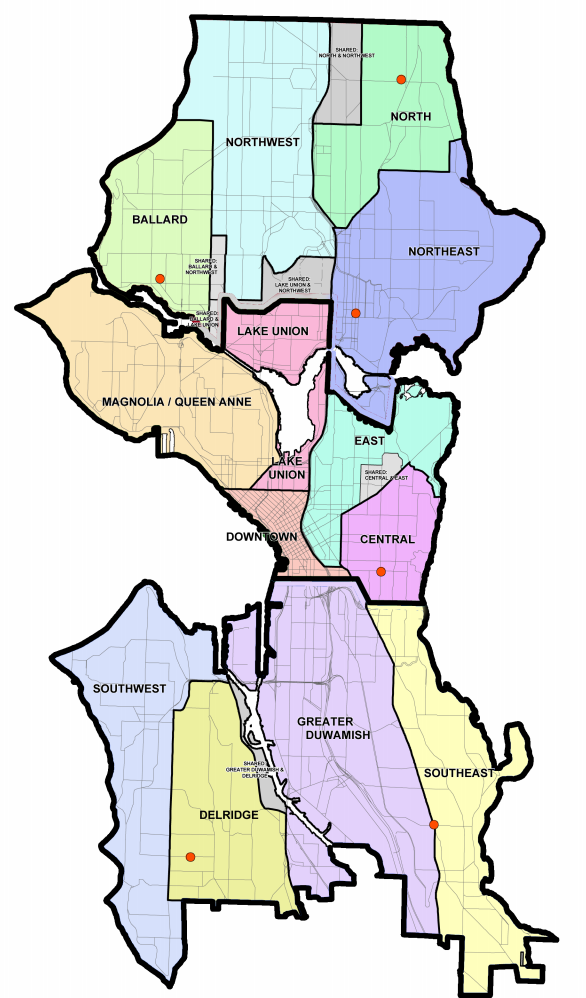

In [127]:
# Afficher les quartiers de Seattle
Image(filename="Map_of_Seattle,_divided_by_districts.png", width=400, height=150)

In [128]:
perform_anova_tukey(df_selected, 'SiteEUIWN_kBtu_sf', 'Neighborhood')

ANOVA Table for SiteEUIWN_kBtu_sf by Neighborhood:
                       sum_sq     df         F    PR(>F)
C(Neighborhood)  2.217687e+05   12.0  3.104336  0.000254
Residual         4.911389e+06  825.0       NaN       NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by Neighborhood:
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
              BALLARD               CENTRAL   3.3511    1.0 -57.0732  63.7754  False
              BALLARD              DELRIDGE -20.4516 0.9977 -84.3986  43.4955  False
              BALLARD              DOWNTOWN  -8.1508    1.0 -51.8608  35.5593  False
              BALLARD                  EAST   4.2655    1.0 -46.8561  55.3871  False
              BALLARD      GREATER DUWAMISH -30.4888 0.4166 -72.0016  11.0241  False
              BALLARD            LAK

In [129]:
# Test avec un regroupement de catégories
def map_areas_neighborhood(neighborhood):
    # Zones résidentielles
    residential = ['EAST', 'NORTHEAST']
    
    # Zones urbaines et centres culturels
    urban_core = ['NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'CENTRAL', 'NORTH', 'LAKE UNION']
    
    # Zones commerces et industrielles
    commercial_industrial = ['DOWNTOWN', 'GREATER DUWAMISH', 'DELRIDGE', 'SOUTHEAST', 'SOUTHWEST']

    if neighborhood in residential:
        return 'residential'
    elif neighborhood in urban_core:
        return 'urban_core'
    else:
        return 'commercial_industrial'

df_test = df_selected.copy()
df_test['GroupedNeighborhood'] = df_test['Neighborhood'].apply(map_areas_neighborhood)

In [130]:
perform_anova_tukey(df_test, 'SiteEUIWN_kBtu_sf', 'GroupedNeighborhood')

ANOVA Table for SiteEUIWN_kBtu_sf by GroupedNeighborhood:
                              sum_sq     df         F    PR(>F)
C(GroupedNeighborhood)  7.776985e+04    2.0  6.422636  0.001706
Residual                5.055388e+06  835.0       NaN       NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by GroupedNeighborhood:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
        group1           group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
commercial_industrial residential  25.2637 0.0072   5.6597 44.8676   True
commercial_industrial  urban_core  15.8083 0.0222   1.8079 29.8086   True
          residential  urban_core  -9.4554 0.5369 -30.3248  11.414  False
-------------------------------------------------------------------------


Les différences semblent plus provenir du type de bâtiment dans ces quartiers que vraiment des quartiers en eux-même. Il faut retirer cette variable pour créer nos modèles.

In [131]:
df_selected = df_selected.drop(columns=['Neighborhood'])

### PropertyUseType

In [132]:
perform_anova_tukey(df_propertyUse, 'SiteEUIWN_kBtu_sf', 'Type')

ANOVA Table for SiteEUIWN_kBtu_sf by Type:
                sum_sq      df          F        PR(>F)
C(Type)   1.896588e+06    12.0  34.386536  5.448620e-70
Residual  6.214126e+06  1352.0        NaN           NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by Type:
                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
         group1                  group2          meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------------------------------
             GFA_Autres    GFA_Bureaux_services  -13.6147 0.3578     -31.5    4.2706  False
             GFA_Autres           GFA_Commerces   -14.017  0.768   -37.928    9.8941  False
             GFA_Autres          GFA_DataCenter  152.9299    0.0   83.6764  222.1833   True
             GFA_Autres           GFA_Education  -24.1107 0.2775  -54.2264     6.005  False
             GFA_Autres             GFA_Hopital  190.9649    0.0  104.7919   277.138   True

Un certain nombre de catégories pourraient être regroupées :<br>
Nous pourrions étudier cela pour améliorer les performances des modèles si besoin.

# Export des données

In [133]:
path     = "data/cleaned/"
filename = "df_cleaned.csv"

In [134]:
df_selected.to_csv(path+filename, index=False)